# Import Packages & Data

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scorecardpy as sc

/var/folders/b0/v962dph15p31189cjj58ctq00000gn/T/ipykernel_12766/1444451492.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
application = pd.read_csv('data/IS453 Group Assignment - Application Data.csv')
bureau = pd.read_csv('data/IS453 Group Assignment - Bureau Data.csv')

print(application.shape)
print(bureau.shape)

# filter for applicants that do not own a car
application = application[application['FLAG_OWN_CAR'] == 'N']

# filter bureau dataset for CREDIT_CURRENCY = currency 1
bureau = bureau[bureau['CREDIT_CURRENCY'] == 'currency 1']

# drop some useless and potentially problematic columns
application = application.drop(columns=['FLAG_OWN_CAR', 'OWN_CAR_AGE', 'CODE_GENDER'])
bureau = bureau.drop(columns=['CREDIT_CURRENCY'])

print(application.shape)
print(bureau.shape)

(307511, 120)
(1716428, 17)
(202924, 117)
(1715020, 16)


# Prepare Data for Preliminary Screening by IV

### Merge datasets

In [4]:
agg_bureau = bureau.copy()

# precompute credit status counts
agg_bureau['NUM_ACTIVE_CREDITS'] = (agg_bureau['CREDIT_ACTIVE'] == 'Active').astype(int)
agg_bureau['NUM_CLOSED_CREDITS'] = (agg_bureau['CREDIT_ACTIVE'] == 'Closed').astype(int)
agg_bureau['NUM_BADDEBT_CREDITS'] = (agg_bureau['CREDIT_ACTIVE'] == 'Bad debt').astype(int)

# precompute top 5 most common credit type counts
agg_bureau['NUM_CONSUMER_CREDIT_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Consumer credit').astype(int)
agg_bureau['NUM_CREDIT_CARD_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Credit card').astype(int)
agg_bureau['NUM_CAR_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Car loan').astype(int)
agg_bureau['NUM_MORTGAGE_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Mortgage').astype(int)
agg_bureau['NUM_MICRO_LOANS'] = (agg_bureau['CREDIT_TYPE'] == 'Microloan').astype(int)

# DEBT_CREDIT_RATIO = AMT_CREDIT_SUM_DEBT / AMT_CREDIT_SUM
agg_bureau['DEBT_CREDIT_RATIO'] = agg_bureau['AMT_CREDIT_SUM_DEBT'] / agg_bureau['AMT_CREDIT_SUM']

# flatten bureau data
agg_bureau = agg_bureau.groupby('SK_ID_CURR').agg(
    NUM_PREV_LOANS = ('SK_ID_BUREAU', 'count'),
    NUM_ACTIVE_CREDITS = ('NUM_ACTIVE_CREDITS', 'sum'),
    NUM_CLOSED_CREDITS = ('NUM_CLOSED_CREDITS', 'sum'),
    NUM_CONSUMER_CREDIT_LOANS = ('NUM_CONSUMER_CREDIT_LOANS', 'sum'),
    NUM_CREDIT_CARD_LOANS = ('NUM_CREDIT_CARD_LOANS', 'sum'),
    NUM_CAR_LOANS = ('NUM_CAR_LOANS', 'sum'),
    NUM_MORTGAGE_LOANS = ('NUM_MORTGAGE_LOANS', 'sum'),
    NUM_MICRO_LOANS = ('NUM_MICRO_LOANS', 'sum'),
    DAYS_CREDIT_MIN = ('DAYS_CREDIT', 'min'), # capture the oldest credit application
    DAYS_CREDIT_MAX = ('DAYS_CREDIT', 'max'), # find most recent credit application
    DAYS_CREDIT_MEAN = ('DAYS_CREDIT', 'mean'), # avg days before current application, for prev credit lines
    DAYS_CREDIT_OVERDUE_MAX = ('CREDIT_DAY_OVERDUE', 'max'),
    DAYS_CREDIT_OVERDUE_MEAN = ('CREDIT_DAY_OVERDUE', 'mean'),
    DAYS_CREDIT_ENDDATE_MEAN = ('DAYS_CREDIT_ENDDATE', 'mean'),
    CNT_CREDIT_PROLONG_MAX = ('CNT_CREDIT_PROLONG', 'max'),
    CNT_CREDIT_PROLONG_MEAN = ('CNT_CREDIT_PROLONG', 'mean'),
    AMT_CREDIT_SUM_LIMIT_MEAN = ('AMT_CREDIT_SUM_LIMIT', 'mean'),
    AMT_CREDIT_SUM_OVERDUE_SUM = ('AMT_CREDIT_SUM_OVERDUE', 'sum'),
    AMT_CREDIT_SUM_OVERDUE_MAX = ('AMT_CREDIT_SUM_OVERDUE', 'max'),
    DAYS_CREDIT_UPDATE_MEAN = ('DAYS_CREDIT_UPDATE', 'mean'),
    DEBT_CREDIT_RATIO_MEAN = ('DEBT_CREDIT_RATIO', 'mean'),
    AMT_ANNUITY_MEAN = ('AMT_ANNUITY', 'mean'),
).reset_index()


In [5]:
print(application.shape)
print(bureau.shape)
print(agg_bureau.shape)

merged = pd.merge(left=application, right=agg_bureau, on='SK_ID_CURR', how='left')
print(merged.shape)

(202924, 117)
(1715020, 16)
(305773, 23)
(202924, 139)


### Dealing with missing values

In [6]:
merged_working = merged.copy()
cols = merged_working.columns[1:]
merged_working = merged_working.loc[:, cols]

In [7]:
# unable to calculate WOE & IV for ORGANIZATION_TYPE as it is because it has too many possible categories
    # group some values together

mapping = {
    'Business Entity Type 1': 'Business Entity',
    'Business Entity Type 2': 'Business Entity',
    'Business Entity Type 3': 'Business Entity',
    'Trade: type 7': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 1': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport',
    'Transport: type 4': 'Transport',
    'Industry: type 3': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 1': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Industry: type 8': 'Industry',
    'Government': 'Public Sector',
    'Transport': 'Public Sector',
    'Military': 'Public Sector',
    'Police': 'Public Sector',
    'Hotel': 'Hospitality',
    'Restaurant': 'Hospitality',
    'Bank': 'Financial Services',
    'Insurance': 'Financial Services',
}

merged_working['ORGANIZATION_TYPE'] = merged_working['ORGANIZATION_TYPE'].replace(mapping)
print(merged_working['ORGANIZATION_TYPE'].value_counts())

ORGANIZATION_TYPE
Business Entity        50934
XNA                    45205
Self-employed          23916
Other                  10739
Trade                   9680
Public Sector           9382
Industry                8752
Medicine                8270
School                  6471
Kindergarten            5404
Transport               4300
Construction            3445
Hospitality             2052
Financial Services      1985
Security                1829
Housing                 1817
Postal                  1684
Agriculture             1450
Services                1122
Security Ministries     1109
University               901
Electricity              568
Telecom                  340
Culture                  271
Advertising              269
Emergency                242
Realtor                  211
Cleaning                 195
Mobile                   185
Legal Services           145
Religion                  51
Name: count, dtype: int64


#### Dropping Rows

In [9]:
# og_shape = iv_above_threshold.shape
# print(og_shape)

# Calculate the percentage of rows with more than 50 missing values
pct_total_rows_missing = merged_working[merged_working.isnull().sum(axis = 1) > 50].shape[0] / merged_working.shape[0]
print(f'Percent of total rows missing more 50 than values: {pct_total_rows_missing:.2%}')

Percent of total rows missing more 50 than values: 10.14%


In [10]:
merged_working.shape

(202924, 138)

In [ ]:
# drop rows with more than 50 missing values per row
# for_analysis = merged_working.dropna(thresh = merged_working.shape[1] - 50)

# print(f'Ending row count: {for_analysis.shape[0]}')
# print(f'Percent dropped: {(1 - for_analysis.shape[0] / og_shape[0]):.2%}')

rows_org = merged_working.shape[0]
print(f'Starting row count: {rows_org}')

# drop rows based on a threshold of more than 35 missing values per row
merged_working = merged_working.dropna(thresh = merged_working.shape[1] - 50)
print(f'Ending row count: {merged_working.shape[0]}')
print(f'Percent dropped: {(1 - merged_working.shape[0] / rows_org):.2%}')

Starting row count: 202924
Ending row count: 182346
Percent dropped: 10.14%


#### Dropping Columns

In [12]:
pd.Series(merged_working.isnull().sum().sort_values(ascending=False)/merged_working.shape[0]).map("{0:.0%}".format)

AMT_ANNUITY_MEAN            72%
COMMONAREA_MEDI             66%
COMMONAREA_MODE             66%
COMMONAREA_AVG              66%
NONLIVINGAPARTMENTS_MEDI    65%
                           ... 
NAME_CONTRACT_TYPE           0%
NAME_INCOME_TYPE             0%
NAME_EDUCATION_TYPE          0%
NAME_FAMILY_STATUS           0%
TARGET                       0%
Length: 138, dtype: object

In [18]:
# Calculate the percentage of missing values for each col
missing_data = merged_working.isnull().mean().sort_values(ascending=False)
missing_data_over_50 = missing_data[missing_data > 0.5].apply(lambda x: "{:.0%}".format(x))
missing_data_over_50
merged_working_copy = merged_working.copy()

merged_working = merged_working.drop(columns=missing_data_over_50.index)
merged_working


,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,DAYS_CREDIT_OVERDUE_MAX,DAYS_CREDIT_OVERDUE_MEAN,DAYS_CREDIT_ENDDATE_MEAN,CNT_CREDIT_PROLONG_MAX,CNT_CREDIT_PROLONG_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_OVERDUE_SUM,AMT_CREDIT_SUM_OVERDUE_MAX,DAYS_CREDIT_UPDATE_MEAN,DEBT_CREDIT_RATIO_MEAN
0,1,Cash loans,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,...,0.0,0.0,-349.000000,0.0,0.000000,7997.14125,0.0,0.0,-499.875000,0.136545
1,0,Cash loans,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,...,0.0,0.0,-544.500000,0.0,0.000000,202500.00000,0.0,0.0,-816.000000,0.000000
3,0,Cash loans,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,...,0.0,0.0,-783.000000,0.0,0.000000,0.00000,0.0,0.0,-783.000000,0.000000
4,0,Cash loans,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,...,0.0,0.0,-391.333333,0.0,0.000000,0.00000,0.0,0.0,-611.000000,0.299018
5,0,Cash loans,Y,0,112500.0,1019610.0,33826.5,913500.0,Children,Pensioner,...,0.0,0.0,-1293.250000,0.0,0.000000,0.00000,0.0,0.0,-1454.750000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202919,0,Cash loans,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202920,0,Cash loans,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202921,0,Cash loans,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,...,0.0,0.0,280.500000,0.0,0.000000,0.00000,0.0,0.0,-253.250000,0.299308
202922,1,Cash loans,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,...,0.0,0.0,-859.000000,0.0,0.000000,NaN,0.0,0.0,-401.000000,0.000000


In [19]:
# one hot encoding
# missing values
#

In [8]:
# calculate bin ranges, WOE, and IV for the independent variables
bins = sc.woebin(merged_working, y='TARGET')

# create a dictionary to store the IVs for each variable
iv_dict = {}

# reverse WOE and store IV values in the dictionary
for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1
    iv_value = bindetails['total_iv'][0]
    iv_dict[variable] = iv_value
    display(bindetails)

# Sort the dictionary by IV values in descending order
iv_dict_sorted = dict(sorted(iv_dict.items(), key=lambda item: item[1], reverse=True))

[INFO] creating woe binning ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ).groupby(['variable', 'rowid', 'bin_chr'], group_keys=False).agg({'bad':sum,'good':sum})\
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <bu

Binning on 202924 rows and 136 columns in 00:00:47


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:413: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['variable', 'bstbin', 'value'], group_keys=False)\
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({'good':sum, 'bad':sum}).reset_index()\
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:414: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In 

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY,missing,9,0.000044,9,0,0.000000,-0.073606,2.725220e-07,0.022672,missing,True
1,AMT_ANNUITY,"[-inf,16000.0)",52107,0.256781,48266,3841,0.073714,0.154803,5.771197e-03,0.022672,16000.0,False
2,AMT_ANNUITY,"[16000.0,24000.0)",52549,0.258959,47845,4704,0.089516,-0.056638,8.504661e-04,0.022672,24000.0,False
3,AMT_ANNUITY,"[24000.0,42000.0)",75246,0.370809,68023,7223,0.095992,-0.133616,6.997720e-03,0.022672,42000.0,False
4,AMT_ANNUITY,"[42000.0,inf)",23013,0.113407,21532,1481,0.064355,0.300631,9.052155e-03,0.022672,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_PHONE,"[-inf,1.0)",145392,0.716485,132373,13019,0.089544,-0.057030,0.002386,0.008977,1.0,False
1,FLAG_PHONE,"[1.0,inf)",57532,0.283515,53302,4230,0.073524,0.157528,0.006591,0.008977,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_7,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BEGINEXPLUATATION_MODE,missing,96458,0.475341,87035,9423,0.097690,-0.153087,0.011871,0.029725,missing,True
1,YEARS_BEGINEXPLUATATION_MODE,"[-inf,0.9740000000000001)",16945,0.083504,15469,1476,0.087105,-0.026741,0.000060,0.029725,0.9740000000000001,False
2,YEARS_BEGINEXPLUATATION_MODE,"[0.9740000000000001,0.9810000000000001)",33748,0.166309,31226,2522,0.074730,0.139955,0.003074,0.029725,0.9810000000000001,False
3,YEARS_BEGINEXPLUATATION_MODE,"[0.9810000000000001,0.9880000000000001)",37352,0.184069,34668,2684,0.071857,0.182265,0.005670,0.029725,0.9880000000000001,False
4,YEARS_BEGINEXPLUATATION_MODE,"[0.9880000000000001,inf)",18421,0.090778,17277,1144,0.062103,0.338602,0.009050,0.029725,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAREA_AVG,missing,110140,0.542765,99607,10533,0.095633,-0.129524,0.009609,0.023766,missing,True
1,NONLIVINGAREA_AVG,"[-inf,0.004)",47619,0.234664,44066,3553,0.074613,0.141653,0.004440,0.023766,0.004,False
2,NONLIVINGAREA_AVG,"[0.004,0.012)",11862,0.058455,11056,806,0.067948,0.242401,0.003107,0.023766,0.012,False
3,NONLIVINGAREA_AVG,"[0.012,0.03)",11529,0.056814,10672,857,0.074334,0.145697,0.001135,0.023766,0.03,False
4,NONLIVINGAREA_AVG,"[0.03,0.066)",10417,0.051334,9654,763,0.073246,0.161626,0.001254,0.023766,0.066,False
5,NONLIVINGAREA_AVG,"[0.066,inf)",11357,0.055967,10620,737,0.064894,0.291663,0.004220,0.023766,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EXT_SOURCE_1,missing,117730,0.580168,107233,10497,0.089162,-0.052329,0.001624,0.151396,missing,True
1,EXT_SOURCE_1,"[-inf,0.26)",12546,0.061826,10390,2156,0.171848,-0.803655,0.055480,0.151396,0.26,False
2,EXT_SOURCE_1,"[0.26,0.42)",17932,0.088368,16099,1833,0.102219,-0.203440,0.003980,0.151396,0.42,False
3,EXT_SOURCE_1,"[0.42,0.56)",17284,0.085175,16089,1195,0.069139,0.223746,0.003887,0.151396,0.56,False
4,EXT_SOURCE_1,"[0.56,0.7000000000000001)",17720,0.087323,16786,934,0.052709,0.512580,0.018585,0.151396,0.7000000000000001,False
5,EXT_SOURCE_1,"[0.7000000000000001,inf)",19712,0.097140,19078,634,0.032163,1.027999,0.067841,0.151396,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,WEEKDAY_APPR_PROCESS_START,MONDAY,33374,0.164466,30668,2706,0.081081,0.051505,0.000427,0.00076,MONDAY,False
1,WEEKDAY_APPR_PROCESS_START,"SUNDAY%,%THURSDAY%,%SATURDAY",66477,0.327596,60885,5592,0.084119,0.011406,0.000042,0.00076,"SUNDAY%,%THURSDAY%,%SATURDAY",False
2,WEEKDAY_APPR_PROCESS_START,FRIDAY,33298,0.164091,30423,2875,0.086342,-0.017097,0.000048,0.00076,FRIDAY,False
3,WEEKDAY_APPR_PROCESS_START,"WEDNESDAY%,%TUESDAY",69775,0.343848,63699,6076,0.087080,-0.026421,0.000243,0.00076,"WEDNESDAY%,%TUESDAY",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_9,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT,"[-inf,150000.0)",13696,0.067493,12848,848,0.061916,0.341819,0.006848,0.042589,150000.0,False
1,AMT_CREDIT,"[150000.0,250000.0)",29381,0.144788,27044,2337,0.079541,0.072353,0.000736,0.042589,250000.0,False
2,AMT_CREDIT,"[250000.0,300000.0)",22133,0.109070,20225,1908,0.086206,-0.015380,0.000026,0.042589,300000.0,False
3,AMT_CREDIT,"[300000.0,650000.0)",68191,0.336042,61026,7165,0.105073,-0.234152,0.020305,0.042589,650000.0,False
4,AMT_CREDIT,"[650000.0,900000.0)",32280,0.159074,29703,2577,0.079833,0.068378,0.000723,0.042589,900000.0,False
5,AMT_CREDIT,"[900000.0,inf)",37243,0.183532,34829,2414,0.064818,0.292922,0.013952,0.042589,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CREDIT_CARD_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.022107,missing,True
1,NUM_CREDIT_CARD_LOANS,"[-inf,2.0)",116770,0.575437,107883,8887,0.076107,0.120214,0.007912,0.022107,2.0,False
2,NUM_CREDIT_CARD_LOANS,"[2.0,3.0)",28138,0.138663,25725,2413,0.085756,-0.009651,0.000013,0.022107,3.0,False
3,NUM_CREDIT_CARD_LOANS,"[3.0,4.0)",13511,0.066582,12241,1270,0.093997,-0.110470,0.000851,0.022107,4.0,False
4,NUM_CREDIT_CARD_LOANS,"[4.0,inf)",13276,0.065424,11875,1401,0.105529,-0.238995,0.004127,0.022107,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMAX_MODE,missing,98563,0.485714,88960,9603,0.097430,-0.150132,0.011652,0.03845,missing,True
1,FLOORSMAX_MODE,"[-inf,0.15000000000000002)",22930,0.112998,20829,2101,0.091627,-0.082311,0.000792,0.03845,0.15000000000000002,False
2,FLOORSMAX_MODE,"[0.15000000000000002,0.25)",46103,0.227193,42697,3406,0.073878,0.152346,0.004950,0.03845,0.25,False
3,FLOORSMAX_MODE,"[0.25,0.35000000000000003)",23631,0.116452,22123,1508,0.063814,0.309590,0.009821,0.03845,0.35000000000000003,False
4,FLOORSMAX_MODE,"[0.35000000000000003,inf)",11697,0.057642,11066,631,0.053945,0.488083,0.011234,0.03845,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ELEVATORS_MODE,missing,106220,0.523447,95991,10229,0.096300,-0.137216,0.010433,0.032239,missing,True
1,ELEVATORS_MODE,"[-inf,0.05)",64839,0.319524,59734,5105,0.078733,0.083437,0.002149,0.032239,0.05,False
2,ELEVATORS_MODE,"[0.05,0.2)",17583,0.086648,16455,1128,0.064153,0.303940,0.007060,0.032239,0.2,False
3,ELEVATORS_MODE,"[0.2,inf)",14282,0.070381,13495,787,0.055104,0.465603,0.012597,0.032239,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_UPDATE_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.094825,missing,True
1,DAYS_CREDIT_UPDATE_MEAN,"[-inf,-700.0)",53475,0.263522,50537,2938,0.054942,0.468733,0.047741,0.094825,-700.0,False
2,DAYS_CREDIT_UPDATE_MEAN,"[-700.0,-350.0)",53120,0.261773,49201,3919,0.073776,0.153834,0.005812,0.094825,-350.0,False
3,DAYS_CREDIT_UPDATE_MEAN,"[-350.0,-100.0)",36354,0.179151,32722,3632,0.099906,-0.177979,0.006110,0.094825,-100.0,False
4,DAYS_CREDIT_UPDATE_MEAN,"[-100.0,inf)",28746,0.141659,25264,3482,0.121130,-0.394470,0.025957,0.094825,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_EDUCATION_TYPE,"Academic degree%,%Higher education",43693,0.215317,41197,2496,0.057126,0.427432,0.032986,0.040284,"Academic degree%,%Higher education",False
1,NAME_EDUCATION_TYPE,"Incomplete higher%,%Secondary / secondary spec...",159231,0.784683,144478,14753,0.092652,-0.094563,0.007298,0.040284,"Incomplete higher%,%Secondary / secondary spec...",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,missing,71985,0.354739,67221,4764,0.066180,0.270654,0.023235,0.091518,missing,True
1,OCCUPATION_TYPE,"Accountants%,%Core staff%,%Managers%,%High ski...",52773,0.260063,49230,3543,0.067137,0.255286,0.015250,0.091518,"Accountants%,%Core staff%,%Managers%,%High ski...",False
2,OCCUPATION_TYPE,"Cleaning staff%,%Sales staff%,%Cooking staff",32268,0.159015,28988,3280,0.101649,-0.197205,0.006712,0.091518,"Cleaning staff%,%Sales staff%,%Cooking staff",False
3,OCCUPATION_TYPE,"Security staff%,%Laborers%,%Waiters/barmen sta...",45898,0.226183,40236,5662,0.123360,-0.415259,0.046322,0.091518,"Security staff%,%Laborers%,%Waiters/barmen sta...",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE,"Security Ministries%,%Culture%,%University%,%X...",55993,0.275931,52870,3123,0.055775,0.452798,0.046951,0.074914,"Security Ministries%,%Culture%,%University%,%X...",False
1,ORGANIZATION_TYPE,"Services%,%Medicine%,%Public Sector%,%Emergenc...",24420,0.120341,22680,1740,0.071253,0.191355,0.004071,0.074914,"Services%,%Medicine%,%Public Sector%,%Emergenc...",False
2,ORGANIZATION_TYPE,"Other%,%Telecom%,%Electricity%,%Housing%,%Post...",122511,0.603728,110125,12386,0.101101,-0.191194,0.023892,0.074914,"Other%,%Telecom%,%Electricity%,%Housing%,%Post...",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMAX_AVG,missing,98563,0.485714,88960,9603,0.097430,-0.150132,0.011652,0.038997,missing,True
1,FLOORSMAX_AVG,"[-inf,0.16)",22797,0.112343,20704,2093,0.091810,-0.084515,0.000831,0.038997,0.16,False
2,FLOORSMAX_AVG,"[0.16,0.24)",44767,0.220610,41440,3327,0.074318,0.145932,0.004422,0.038997,0.24,False
3,FLOORSMAX_AVG,"[0.24,0.36)",24194,0.119227,22647,1547,0.063941,0.307466,0.009926,0.038997,0.36,False
4,FLOORSMAX_AVG,"[0.36,inf)",12603,0.062107,11924,679,0.053876,0.489444,0.012165,0.038997,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_OVERDUE_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,AMT_CREDIT_SUM_OVERDUE_MAX,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_WEEK,missing,29497,0.14536,26331,3166,0.107333,-0.257966,0.010766,0.012847,missing,True
1,AMT_REQ_CREDIT_BUREAU_WEEK,"[-inf,inf)",173427,0.85464,159344,14083,0.081204,0.049853,0.002081,0.012847,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_HOUR,missing,29497,0.14536,26331,3166,0.107333,-0.257966,0.010766,0.012847,missing,True
1,AMT_REQ_CREDIT_BUREAU_HOUR,"[-inf,inf)",173427,0.85464,159344,14083,0.081204,0.049853,0.002081,0.012847,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_LIMIT_MEAN,missing,44926,0.221393,40492,4434,0.098696,-0.164441,0.006410,0.017463,missing,True
1,AMT_CREDIT_SUM_LIMIT_MEAN,"[-inf,2000.0)",134251,0.661583,123584,10667,0.079456,0.073523,0.003469,0.017463,2000.0,False
2,AMT_CREDIT_SUM_LIMIT_MEAN,"[2000.0,20000.0)",12393,0.061072,11039,1354,0.109255,-0.277872,0.005292,0.017463,20000.0,False
3,AMT_CREDIT_SUM_LIMIT_MEAN,"[20000.0,inf)",11354,0.055952,10560,794,0.069931,0.211501,0.002293,0.017463,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_ANNUITY_MEAN,missing,152089,0.749487,139227,12862,0.084569,0.005585,0.000023,0.005444,missing,True
1,AMT_ANNUITY_MEAN,"[-inf,2000.0)",15639,0.077068,14534,1105,0.070657,0.200402,0.002849,0.005444,2000.0,False
2,AMT_ANNUITY_MEAN,"[2000.0,12000.0)",20266,0.099870,18285,1981,0.097750,-0.153764,0.002517,0.005444,12000.0,False
3,AMT_ANNUITY_MEAN,"[12000.0,inf)",14930,0.073574,13629,1301,0.087140,-0.027177,0.000055,0.005444,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BUILD_MODE,missing,133730,0.659015,121453,12277,0.091804,-0.084444,0.004867,0.018029,missing,True
1,YEARS_BUILD_MODE,"[-inf,0.6700000000000004)",12001,0.059140,11020,981,0.081743,0.042651,0.000106,0.018029,0.6700000000000004,False
2,YEARS_BUILD_MODE,"[0.6700000000000004,0.8000000000000005)",33533,0.165249,31093,2440,0.072764,0.168741,0.004388,0.018029,0.8000000000000005,False
3,YEARS_BUILD_MODE,"[0.8000000000000005,0.8400000000000005)",11286,0.055617,10497,789,0.069910,0.211835,0.002286,0.018029,0.8400000000000005,False
4,YEARS_BUILD_MODE,"[0.8400000000000005,inf)",12374,0.060978,11612,762,0.061581,0.347604,0.006383,0.018029,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_REGION_NOT_LIVE_REGION,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEF_60_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.012796,missing,True
1,DEF_60_CNT_SOCIAL_CIRCLE,"[-inf,1.0)",184598,0.909690,169368,15230,0.082504,0.032563,0.000952,0.012796,1.0,False
2,DEF_60_CNT_SOCIAL_CIRCLE,"[1.0,inf)",17668,0.087067,15672,1996,0.112973,-0.315513,0.009879,0.012796,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_INCOME_TOTAL,"[-inf,80000.0)",22711,0.111919,20854,1857,0.081767,0.042340,0.000197,0.004895,80000.0,False
1,AMT_INCOME_TOTAL,"[80000.0,190000.0)",132931,0.655078,121211,11720,0.088166,-0.040008,0.001066,0.004895,190000.0,False
2,AMT_INCOME_TOTAL,"[190000.0,220000.0)",12749,0.062826,11675,1074,0.084242,0.009816,0.000006,0.004895,220000.0,False
3,AMT_INCOME_TOTAL,"[220000.0,260000.0)",16257,0.080114,14950,1307,0.080396,0.060733,0.000288,0.004895,260000.0,False
4,AMT_INCOME_TOTAL,"[260000.0,inf)",18276,0.090063,16985,1291,0.070639,0.200670,0.003338,0.004895,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_YEAR,missing,29497,0.145360,26331,3166,0.107333,-0.257966,0.010766,0.015699,missing,True
1,AMT_REQ_CREDIT_BUREAU_YEAR,"[-inf,2.0)",86586,0.426692,79916,6670,0.077033,0.107113,0.004683,0.015699,2.0,False
2,AMT_REQ_CREDIT_BUREAU_YEAR,"[2.0,5.0)",68519,0.337658,62736,5783,0.084400,0.007769,0.000020,0.015699,5.0,False
3,AMT_REQ_CREDIT_BUREAU_YEAR,"[5.0,inf)",18322,0.090290,16692,1630,0.088964,-0.049894,0.000229,0.015699,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,TOTALAREA_MODE,missing,95395,0.470102,86041,9354,0.098055,-0.157224,0.012404,0.038195,missing,True
1,TOTALAREA_MODE,"[-inf,0.03)",20953,0.103255,19011,1942,0.092684,-0.094944,0.000968,0.038195,0.03,False
2,TOTALAREA_MODE,"[0.03,0.08)",43243,0.213099,40021,3222,0.074509,0.143158,0.004116,0.038195,0.08,False
3,TOTALAREA_MODE,"[0.08,0.15)",21565,0.106271,20103,1462,0.067795,0.244820,0.005756,0.038195,0.15,False
4,TOTALAREA_MODE,"[0.15,inf)",21768,0.107272,20499,1269,0.058297,0.405903,0.014951,0.038195,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,COMMONAREA_AVG,missing,140779,0.693752,128020,12759,0.090631,-0.070294,0.003530,0.014368,missing,True
1,COMMONAREA_AVG,"[-inf,0.005)",11776,0.058032,10837,939,0.079738,0.069662,0.000274,0.014368,0.005,False
2,COMMONAREA_AVG,"[0.005,0.015)",14405,0.070987,13327,1078,0.074835,0.138441,0.001285,0.014368,0.015,False
3,COMMONAREA_AVG,"[0.015,0.07)",25558,0.125949,23729,1829,0.071563,0.186685,0.004063,0.014368,0.07,False
4,COMMONAREA_AVG,"[0.07,inf)",10406,0.051280,9762,644,0.061887,0.342310,0.005217,0.014368,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CHILDREN,"[-inf,1.0)",149149,0.734999,137218,11931,0.079994,0.066187,0.003133,0.011253,1.0,False
1,CNT_CHILDREN,"[1.0,2.0)",36506,0.179900,32960,3546,0.097135,-0.146769,0.004119,0.011253,2.0,False
2,CNT_CHILDREN,"[2.0,inf)",17269,0.085101,15497,1772,0.102612,-0.207706,0.004002,0.011253,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT,"[-inf,2.0)",20329,0.100180,19269,1060,0.052142,0.523985,0.022178,0.044398,2.0,False
1,REGION_RATING_CLIENT,"[2.0,3.0)",149939,0.738892,137525,12414,0.082794,0.028737,0.000603,0.044398,3.0,False
2,REGION_RATING_CLIENT,"[3.0,inf)",32656,0.160927,28881,3775,0.115599,-0.341460,0.021617,0.044398,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAPARTMENTS_MODE,missing,137648,0.678323,125109,12539,0.091095,-0.075902,0.004033,0.017959,missing,True
1,LIVINGAPARTMENTS_MODE,"[-inf,0.04)",12452,0.061363,11369,1083,0.086974,-0.025088,0.000039,0.017959,0.04,False
2,LIVINGAPARTMENTS_MODE,"[0.04,0.09)",25520,0.125761,23666,1854,0.072649,0.170450,0.003405,0.017959,0.09,False
3,LIVINGAPARTMENTS_MODE,"[0.09,0.16)",15818,0.077950,14745,1073,0.067834,0.244202,0.004202,0.017959,0.16,False
4,LIVINGAPARTMENTS_MODE,"[0.16,inf)",11486,0.056602,10786,700,0.060944,0.358680,0.006280,0.017959,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,COMMONAREA_MODE,missing,140779,0.693752,128020,12759,0.090631,-0.070294,0.003530,0.013807,missing,True
1,COMMONAREA_MODE,"[-inf,0.005)",12874,0.063442,11868,1006,0.078142,0.091620,0.000513,0.013807,0.005,False
2,COMMONAREA_MODE,"[0.005,0.015)",14790,0.072884,13684,1106,0.074780,0.139234,0.001334,0.013807,0.015,False
3,COMMONAREA_MODE,"[0.015,0.065)",23686,0.116724,21995,1691,0.071392,0.189251,0.003865,0.013807,0.065,False
4,COMMONAREA_MODE,"[0.065,inf)",10795,0.053197,10108,687,0.063641,0.312505,0.004566,0.013807,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAPARTMENTS_MEDI,missing,137648,0.678323,125109,12539,0.091095,-0.075902,0.004033,0.018737,missing,True
1,LIVINGAPARTMENTS_MEDI,"[-inf,0.045)",13623,0.067134,12434,1189,0.087279,-0.028922,0.000057,0.018737,0.045,False
2,LIVINGAPARTMENTS_MEDI,"[0.045,0.085)",23672,0.116655,21947,1725,0.072871,0.167160,0.003042,0.018737,0.085,False
3,LIVINGAPARTMENTS_MEDI,"[0.085,0.145)",15311,0.075452,14280,1031,0.067337,0.252087,0.004320,0.018737,0.145,False
4,LIVINGAPARTMENTS_MEDI,"[0.145,inf)",12670,0.062437,11905,765,0.060379,0.368594,0.007286,0.018737,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BEGINEXPLUATATION_MEDI,missing,96458,0.475341,87035,9423,0.097690,-0.153087,0.011871,0.029677,missing,True
1,YEARS_BEGINEXPLUATATION_MEDI,"[-inf,0.9740000000000001)",16117,0.079424,14716,1401,0.086927,-0.024495,0.000048,0.029677,0.9740000000000001,False
2,YEARS_BEGINEXPLUATATION_MEDI,"[0.9740000000000001,0.9840000000000001)",48963,0.241287,45308,3655,0.074648,0.141144,0.004534,0.029677,0.9840000000000001,False
3,YEARS_BEGINEXPLUATATION_MEDI,"[0.9840000000000001,0.9900000000000001)",29485,0.145301,27428,2057,0.069764,0.214072,0.006094,0.029677,0.9900000000000001,False
4,YEARS_BEGINEXPLUATATION_MEDI,"[0.9900000000000001,inf)",11901,0.058648,11188,713,0.059911,0.376872,0.007130,0.029677,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,APARTMENTS_AVG,missing,100648,0.495989,90888,9760,0.096972,-0.144908,0.011061,0.034907,missing,True
1,APARTMENTS_AVG,"[-inf,0.02)",12304,0.060634,11110,1194,0.097042,-0.145707,0.001368,0.034907,0.02,False
2,APARTMENTS_AVG,"[0.02,0.05)",11257,0.055474,10310,947,0.084125,0.011327,0.000007,0.034907,0.05,False
3,APARTMENTS_AVG,"[0.05,0.17)",59517,0.293297,55322,4195,0.070484,0.203034,0.011116,0.034907,0.17,False
4,APARTMENTS_AVG,"[0.17,inf)",19198,0.094607,18045,1153,0.060058,0.374258,0.011356,0.034907,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ELEVATORS_AVG,missing,106220,0.523447,95991,10229,0.096300,-0.137216,0.010433,0.03353,missing,True
1,ELEVATORS_AVG,"[-inf,0.02)",59209,0.291779,54473,4736,0.079988,0.066269,0.001247,0.03353,0.02,False
2,ELEVATORS_AVG,"[0.02,0.09)",11019,0.054301,10285,734,0.066612,0.263689,0.003386,0.03353,0.09,False
3,ELEVATORS_AVG,"[0.09,0.21)",13848,0.068242,12982,866,0.062536,0.331190,0.006528,0.03353,0.21,False
4,ELEVATORS_AVG,"[0.21,inf)",12628,0.062230,11944,684,0.054165,0.483783,0.011936,0.03353,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_QRT,missing,29497,0.145360,26331,3166,0.107333,-0.257966,0.010766,0.015709,missing,True
1,AMT_REQ_CREDIT_BUREAU_QRT,"[-inf,1.0)",140174,0.690771,128614,11560,0.082469,0.033021,0.000743,0.015709,1.0,False
2,AMT_REQ_CREDIT_BUREAU_QRT,"[1.0,2.0)",21844,0.107646,20308,1536,0.070317,0.205590,0.004179,0.015709,2.0,False
3,AMT_REQ_CREDIT_BUREAU_QRT,"[2.0,inf)",11409,0.056223,10422,987,0.086511,-0.019239,0.000021,0.015709,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMIN_AVG,missing,136576,0.673040,124124,12452,0.091173,-0.076844,0.004103,0.018411,missing,True
1,FLOORSMIN_AVG,"[-inf,0.2)",22719,0.111958,20879,1840,0.080989,0.052735,0.000305,0.018411,0.2,False
2,FLOORSMIN_AVG,"[0.2,0.24)",22619,0.111465,20936,1683,0.074406,0.144649,0.002197,0.018411,0.24,False
3,FLOORSMIN_AVG,"[0.24,inf)",21010,0.103536,19736,1274,0.060638,0.364039,0.011807,0.018411,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,COMMONAREA_MEDI,missing,140779,0.693752,128020,12759,0.090631,-0.070294,0.003530,0.014201,missing,True
1,COMMONAREA_MEDI,"[-inf,0.005)",11886,0.058574,10942,944,0.079421,0.073994,0.000311,0.014201,0.005,False
2,COMMONAREA_MEDI,"[0.005,0.015)",14461,0.071263,13378,1083,0.074891,0.137633,0.001275,0.014201,0.015,False
3,COMMONAREA_MEDI,"[0.015,0.065)",24416,0.120321,22668,1748,0.071592,0.186238,0.003864,0.014201,0.065,False
4,COMMONAREA_MEDI,"[0.065,inf)",11382,0.056090,10667,715,0.062818,0.326384,0.005222,0.014201,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_5,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_14,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_20,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_EMPLOYED,"[-inf,-4000.0)",28347,0.139693,26856,1491,0.052598,0.514799,0.029961,0.126721,-4000.0,False
1,DAYS_EMPLOYED,"[-4000.0,-2000.0)",38617,0.190303,35634,2983,0.077246,0.104127,0.001976,0.126721,-2000.0,False
2,DAYS_EMPLOYED,"[-2000.0,-1000.0)",38474,0.189598,34491,3983,0.103524,-0.217581,0.009824,0.126721,-1000.0,False
3,DAYS_EMPLOYED,"[-1000.0,0.0)",52279,0.257628,45984,6295,0.120412,-0.387706,0.045474,0.126721,0.0,False
4,DAYS_EMPLOYED,"[0.0,inf)",45207,0.222778,42710,2497,0.055235,0.463099,0.039486,0.126721,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_GOODS_PRICE,missing,278,0.001370,257,21,0.075540,0.128310,0.000021,0.047274,missing,True
1,AMT_GOODS_PRICE,"[-inf,150000.0)",18562,0.091473,17301,1261,0.067934,0.242616,0.004870,0.047274,150000.0,False
2,AMT_GOODS_PRICE,"[150000.0,300000.0)",56083,0.276374,51125,4958,0.088405,-0.042972,0.000520,0.047274,300000.0,False
3,AMT_GOODS_PRICE,"[300000.0,500000.0)",52083,0.256663,46487,5596,0.107444,-0.259123,0.019190,0.047274,500000.0,False
4,AMT_GOODS_PRICE,"[500000.0,900000.0)",43751,0.215603,40251,3500,0.079998,0.066128,0.000917,0.047274,900000.0,False
5,AMT_GOODS_PRICE,"[900000.0,1100000.0)",15600,0.076876,14571,1029,0.065962,0.274202,0.005161,0.047274,1100000.0,False
6,AMT_GOODS_PRICE,"[1100000.0,inf)",16567,0.081641,15683,884,0.053359,0.499632,0.016595,0.047274,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_3,"[-inf,1.0)",54216,0.267174,50733,3483,0.064243,0.302439,0.021567,0.028242,1.0,False
1,FLAG_DOCUMENT_3,"[1.0,inf)",148708,0.732826,134942,13766,0.092571,-0.093600,0.006675,0.028242,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_11,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_18,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_ID_PUBLISH,"[-inf,-4100.0)",67616,0.333208,63266,4350,0.064334,0.300929,0.026646,0.048556,-4100.0,False
1,DAYS_ID_PUBLISH,"[-4100.0,-2900.0)",46677,0.230022,42825,3852,0.082525,0.032286,0.000237,0.048556,-2900.0,False
2,DAYS_ID_PUBLISH,"[-2900.0,-1900.0)",32715,0.161218,29647,3068,0.093780,-0.107909,0.001963,0.048556,-1900.0,False
3,DAYS_ID_PUBLISH,"[-1900.0,inf)",55916,0.275551,49937,5979,0.106928,-0.253735,0.019710,0.048556,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_CONTRACT_TYPE,Revolving loans,19149,0.094365,18014,1135,0.059272,0.388273,0.012121,0.013182,Revolving loans,False
1,NAME_CONTRACT_TYPE,Cash loans,183775,0.905635,167661,16114,0.087683,-0.033988,0.001061,0.013182,Cash loans,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAPARTMENTS_AVG,missing,139942,0.689628,127257,12685,0.090645,-0.070455,0.003525,0.012449,missing,True
1,NONLIVINGAPARTMENTS_AVG,"[-inf,0.0035)",38461,0.189534,35670,2791,0.072567,0.171666,0.005202,0.012449,0.0035,False
2,NONLIVINGAPARTMENTS_AVG,"[0.0035,0.01)",14346,0.070696,13270,1076,0.075003,0.136012,0.001236,0.012449,0.01,False
3,NONLIVINGAPARTMENTS_AVG,"[0.01,inf)",10175,0.050142,9478,697,0.068501,0.233700,0.002486,0.012449,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVE_REGION_NOT_WORK_REGION,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_21,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_16,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_4,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BEGINEXPLUATATION_AVG,missing,96458,0.475341,87035,9423,0.097690,-0.153087,0.011871,0.029532,missing,True
1,YEARS_BEGINEXPLUATATION_AVG,"[-inf,0.9740000000000001)",16074,0.079212,14682,1392,0.086599,-0.020363,0.000033,0.029532,0.9740000000000001,False
2,YEARS_BEGINEXPLUATATION_AVG,"[0.9740000000000001,0.9810000000000001)",33139,0.163307,30623,2516,0.075923,0.122837,0.002342,0.029532,0.9810000000000001,False
3,YEARS_BEGINEXPLUATATION_AVG,"[0.9810000000000001,0.9850000000000001)",21117,0.104064,19591,1526,0.072264,0.176177,0.003003,0.029532,0.9850000000000001,False
4,YEARS_BEGINEXPLUATATION_AVG,"[0.9850000000000001,0.9900000000000001)",24270,0.119601,22598,1672,0.068892,0.227597,0.005639,0.029532,0.9900000000000001,False
5,YEARS_BEGINEXPLUATATION_AVG,"[0.9900000000000001,inf)",11866,0.058475,11146,720,0.060678,0.363341,0.006645,0.029532,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,WALLSMATERIAL_MODE,missing,100866,0.497063,91105,9761,0.096772,-0.142626,0.010728,0.028618,missing,True
1,WALLSMATERIAL_MODE,"Monolithic%,%Panel",45214,0.222812,42247,2967,0.065621,0.279738,0.015532,0.028618,"Monolithic%,%Panel",False
2,WALLSMATERIAL_MODE,"Stone, brick",44291,0.218264,40871,3420,0.077217,0.104537,0.002284,0.028618,"Stone, brick",False
3,WALLSMATERIAL_MODE,"Block%,%Mixed%,%Others%,%Wooden",12553,0.061861,11452,1101,0.087708,-0.034298,0.000074,0.028618,"Block%,%Mixed%,%Others%,%Wooden",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BASEMENTAREA_AVG,missing,116864,0.575900,105846,11018,0.094281,-0.113789,0.007817,0.024272,missing,True
1,BASEMENTAREA_AVG,"[-inf,0.045)",22135,0.109080,20357,1778,0.080325,0.061692,0.000405,0.024272,0.045,False
2,BASEMENTAREA_AVG,"[0.045,0.09)",32259,0.158971,29854,2405,0.074553,0.142525,0.003044,0.024272,0.09,False
3,BASEMENTAREA_AVG,"[0.09,0.13)",16289,0.080271,15156,1133,0.069556,0.217284,0.003464,0.024272,0.13,False
4,BASEMENTAREA_AVG,"[0.13,inf)",15377,0.075777,14462,915,0.059504,0.384112,0.009542,0.024272,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LANDAREA_AVG,missing,118423,0.583583,107363,11060,0.093394,-0.103363,0.006508,0.019366,missing,True
1,LANDAREA_AVG,"[-inf,0.005)",11320,0.055784,10479,841,0.074293,0.146293,0.001124,0.019366,0.005,False
2,LANDAREA_AVG,"[0.005,0.05)",32267,0.159010,29702,2565,0.079493,0.073012,0.000822,0.019366,0.05,False
3,LANDAREA_AVG,"[0.05,0.075)",15242,0.075112,14155,1087,0.071316,0.190403,0.002517,0.019366,0.075,False
4,LANDAREA_AVG,"[0.075,inf)",25672,0.126510,23976,1696,0.066064,0.272537,0.008395,0.019366,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAREA_AVG,missing,99450,0.490085,89808,9642,0.096953,-0.144698,0.010897,0.035716,missing,True
1,LIVINGAREA_AVG,"[-inf,0.03)",18658,0.091946,16911,1747,0.093633,-0.106179,0.001083,0.035716,0.03,False
2,LIVINGAREA_AVG,"[0.03,0.07)",30546,0.150529,28186,2360,0.077261,0.103920,0.001557,0.035716,0.07,False
3,LIVINGAREA_AVG,"[0.07,0.18)",38399,0.189228,35821,2578,0.067137,0.255277,0.011096,0.035716,0.18,False
4,LIVINGAREA_AVG,"[0.18,inf)",15871,0.078212,14949,922,0.058093,0.409611,0.011084,0.035716,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_POPULATION_RELATIVE,"[-inf,0.012)",71064,0.350200,64852,6212,0.087414,-0.030619,0.000333,0.033316,0.012,False
1,REGION_POPULATION_RELATIVE,"[0.012,0.02)",45336,0.223414,41053,4283,0.094472,-0.116033,0.003156,0.033316,0.02,False
2,REGION_POPULATION_RELATIVE,"[0.02,0.021)",10304,0.050778,9103,1201,0.116557,-0.350794,0.007227,0.033316,0.021,False
3,REGION_POPULATION_RELATIVE,"[0.021,0.032)",48653,0.239760,44710,3943,0.081043,0.052012,0.000635,0.033316,0.032,False
4,REGION_POPULATION_RELATIVE,"[0.032,0.036000000000000004)",13870,0.068351,12935,935,0.067412,0.250902,0.003879,0.033316,0.036000000000000004,False
5,REGION_POPULATION_RELATIVE,"[0.036000000000000004,inf)",13697,0.067498,13022,675,0.049281,0.583439,0.018087,0.033316,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ENTRANCES_MEDI,missing,99771,0.491667,90068,9703,0.097253,-0.148114,0.011470,0.030675,missing,True
1,ENTRANCES_MEDI,"[-inf,0.06)",11701,0.057662,10732,969,0.082813,0.028477,0.000046,0.030675,0.06,False
2,ENTRANCES_MEDI,"[0.06,0.08)",16586,0.081735,15158,1428,0.086097,-0.013990,0.000016,0.030675,0.08,False
3,ENTRANCES_MEDI,"[0.08,0.14)",39613,0.195211,36730,2883,0.072779,0.168519,0.005170,0.030675,0.14,False
4,ENTRANCES_MEDI,"[0.14,inf)",35253,0.173725,32987,2266,0.064278,0.301854,0.013973,0.030675,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CONSUMER_CREDIT_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.018024,missing,True
1,NUM_CONSUMER_CREDIT_LOANS,"[-inf,2.0)",42830,0.211064,38884,3946,0.092132,-0.088363,0.001710,0.018024,2.0,False
2,NUM_CONSUMER_CREDIT_LOANS,"[2.0,3.0)",28429,0.140097,26053,2376,0.083577,0.018471,0.000047,0.018024,3.0,False
3,NUM_CONSUMER_CREDIT_LOANS,"[3.0,4.0)",23678,0.116684,21794,1884,0.079568,0.071994,0.000587,0.018024,4.0,False
4,NUM_CONSUMER_CREDIT_LOANS,"[4.0,inf)",76758,0.378260,70993,5765,0.075106,0.134532,0.006475,0.018024,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_LAST_PHONE_CHANGE,"[-inf,-1100.0)",76263,0.375821,71344,4919,0.064500,0.298164,0.029538,0.046878,-1100.0,False
1,DAYS_LAST_PHONE_CHANGE,"[-1100.0,-700.0)",28310,0.139510,25837,2473,0.087354,-0.029868,0.000126,0.046878,-700.0,False
2,DAYS_LAST_PHONE_CHANGE,"[-700.0,inf)",98351,0.484669,88494,9857,0.100223,-0.181491,0.017214,0.046878,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_OVERDUE_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,DAYS_CREDIT_OVERDUE_MAX,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.120132,missing,True
1,DAYS_CREDIT_MEAN,"[-inf,-1200.0)",66845,0.329409,63117,3728,0.055771,0.452875,0.056068,0.120132,-1200.0,False
2,DAYS_CREDIT_MEAN,"[-1200.0,-850.0)",40261,0.198404,37323,2938,0.072974,0.165637,0.005082,0.120132,-850.0,False
3,DAYS_CREDIT_MEAN,"[-850.0,-500.0)",35046,0.172705,31700,3346,0.095475,-0.127693,0.002969,0.120132,-500.0,False
4,DAYS_CREDIT_MEAN,"[-500.0,inf)",29543,0.145587,25584,3959,0.134008,-0.510268,0.046808,0.120132,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ENTRANCES_AVG,missing,99771,0.491667,90068,9703,0.097253,-0.148114,0.011470,0.030805,missing,True
1,ENTRANCES_AVG,"[-inf,0.06)",11472,0.056533,10517,955,0.083246,0.022793,0.000029,0.030805,0.06,False
2,ENTRANCES_AVG,"[0.06,0.07)",15866,0.078187,14493,1373,0.086537,-0.019576,0.000030,0.030805,0.07,False
3,ENTRANCES_AVG,"[0.07,0.16)",40732,0.200725,37768,2964,0.072768,0.168679,0.005326,0.030805,0.16,False
4,ENTRANCES_AVG,"[0.16,inf)",35083,0.172887,32829,2254,0.064248,0.302362,0.013949,0.030805,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_BIRTH,"[-inf,-20000.0)",54906,0.270574,52015,2891,0.052654,0.513686,0.057808,0.110569,-20000.0,False
1,DAYS_BIRTH,"[-20000.0,-18000.0)",26029,0.128270,24192,1837,0.070575,0.201645,0.004798,0.110569,-18000.0,False
2,DAYS_BIRTH,"[-18000.0,-13500.0)",60493,0.298107,55250,5243,0.086671,-0.021269,0.000136,0.110569,-13500.0,False
3,DAYS_BIRTH,"[-13500.0,inf)",61496,0.303049,54218,7278,0.118349,-0.368087,0.047826,0.110569,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAREA_MEDI,missing,110140,0.542765,99607,10533,0.095633,-0.129524,0.009609,0.023377,missing,True
1,NONLIVINGAREA_MEDI,"[-inf,0.004)",48793,0.240450,45165,3628,0.074355,0.145397,0.004786,0.023377,0.004,False
2,NONLIVINGAREA_MEDI,"[0.004,0.048)",28570,0.140792,26502,2068,0.072384,0.174395,0.003984,0.023377,0.048,False
3,NONLIVINGAREA_MEDI,"[0.048,inf)",15421,0.075994,14401,1020,0.066144,0.271251,0.004998,0.023377,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OBS_60_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.002823,missing,True
1,OBS_60_CNT_SOCIAL_CIRCLE,"[-inf,2.0)",141144,0.695551,129287,11857,0.084006,0.012873,0.000115,0.002823,2.0,False
2,OBS_60_CNT_SOCIAL_CIRCLE,"[2.0,4.0)",32826,0.161765,30025,2801,0.085329,-0.004190,0.000003,0.002823,4.0,False
3,OBS_60_CNT_SOCIAL_CIRCLE,"[4.0,inf)",28296,0.139441,25728,2568,0.090755,-0.071791,0.000740,0.002823,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_CREDIT_SUM_OVERDUE_SUM,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,AMT_CREDIT_SUM_OVERDUE_SUM,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAPARTMENTS_MEDI,missing,139942,0.689628,127257,12685,0.090645,-0.070455,0.003525,0.012266,missing,True
1,NONLIVINGAPARTMENTS_MEDI,"[-inf,0.0019)",37811,0.186331,35060,2751,0.072757,0.168853,0.004954,0.012266,0.0019,False
2,NONLIVINGAPARTMENTS_MEDI,"[0.0019,0.0078)",10659,0.052527,9871,788,0.073928,0.151615,0.001134,0.012266,0.0078,False
3,NONLIVINGAPARTMENTS_MEDI,"[0.0078,inf)",14512,0.071514,13487,1025,0.070631,0.200790,0.002653,0.012266,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_8,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_2,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_EMP_PHONE,"[-inf,1.0)",45207,0.222778,42711,2496,0.055213,0.463523,0.039551,0.048519,1.0,False
1,FLAG_EMP_PHONE,"[1.0,inf)",157717,0.777222,142964,14753,0.093541,-0.105097,0.008968,0.048519,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REGION_RATING_CLIENT_W_CITY,"[-inf,2.0)",21576,0.106326,20452,1124,0.052095,0.524943,0.023615,0.047044,2.0,False
1,REGION_RATING_CLIENT_W_CITY,"[2.0,3.0)",151808,0.748103,139180,12628,0.083184,0.023608,0.000413,0.047044,3.0,False
2,REGION_RATING_CLIENT_W_CITY,"[3.0,inf)",29540,0.145572,26043,3497,0.118382,-0.368400,0.023016,0.047044,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,HOUSETYPE_MODE,missing,99391,0.489794,89742,9649,0.097081,-0.146159,0.011118,0.023232,missing,True
1,HOUSETYPE_MODE,"block of flats%,%terraced house%,%specific hou...",103533,0.510206,95933,7600,0.073407,0.159258,0.012114,0.023232,"block of flats%,%terraced house%,%specific hou...",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_10,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CAR_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,NUM_CAR_LOANS,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_FAMILY_STATUS,"Unknown%,%Widow",14345,0.070691,13490,855,0.059603,0.382359,0.008827,0.022698,"Unknown%,%Widow",False
1,NAME_FAMILY_STATUS,Married,119182,0.587323,109590,9592,0.080482,0.059573,0.002034,0.022698,Married,False
2,NAME_FAMILY_STATUS,Separated,15214,0.074974,13942,1272,0.083607,0.018072,0.000024,0.022698,Separated,False
3,NAME_FAMILY_STATUS,"Single / not married%,%Civil marriage",54183,0.267011,48653,5530,0.102062,-0.201718,0.011814,0.022698,"Single / not married%,%Civil marriage",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_PREV_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.016002,missing,True
1,NUM_PREV_LOANS,"[-inf,2.0)",25083,0.123608,22812,2271,0.090539,-0.069177,0.000609,0.016002,2.0,False
2,NUM_PREV_LOANS,"[2.0,4.0)",45684,0.225129,41924,3760,0.082305,0.035196,0.000275,0.016002,4.0,False
3,NUM_PREV_LOANS,"[4.0,8.0)",59320,0.292326,54861,4459,0.075169,0.133635,0.004939,0.016002,8.0,False
4,NUM_PREV_LOANS,"[8.0,10.0)",15936,0.078532,14684,1252,0.078564,0.085773,0.000558,0.016002,10.0,False
5,NUM_PREV_LOANS,"[10.0,13.0)",13522,0.066636,12401,1121,0.082902,0.027312,0.000049,0.016002,13.0,False
6,NUM_PREV_LOANS,"[13.0,inf)",12150,0.059875,11042,1108,0.091193,-0.077094,0.000367,0.016002,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Businessman%,%Student%,%Pensioner",45214,0.222812,42724,2490,0.055071,0.466234,0.039977,0.072642,"Businessman%,%Student%,%Pensioner",False
1,NAME_INCOME_TYPE,State servant,14243,0.070189,13367,876,0.061504,0.348935,0.007399,0.072642,State servant,False
2,NAME_INCOME_TYPE,Commercial associate,43576,0.214740,40011,3565,0.081811,0.041747,0.000368,0.072642,Commercial associate,False
3,NAME_INCOME_TYPE,"Working%,%Maternity leave%,%Unemployed",99891,0.492258,89573,10318,0.103293,-0.215080,0.024898,0.072642,"Working%,%Maternity leave%,%Unemployed",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_OVERDUE_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,DAYS_CREDIT_OVERDUE_MEAN,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OBS_30_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.002797,missing,True
1,OBS_30_CNT_SOCIAL_CIRCLE,"[-inf,2.0)",140591,0.692826,128786,11805,0.083967,0.013385,0.000123,0.002797,2.0,False
2,OBS_30_CNT_SOCIAL_CIRCLE,"[2.0,4.0)",32939,0.162322,30120,2819,0.085582,-0.007436,0.000009,0.002797,4.0,False
3,OBS_30_CNT_SOCIAL_CIRCLE,"[4.0,inf)",28736,0.141610,26134,2602,0.090548,-0.069287,0.000700,0.002797,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_ACTIVE_CREDITS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.055155,missing,True
1,NUM_ACTIVE_CREDITS,"[-inf,1.0)",31737,0.156398,29845,1892,0.059615,0.382139,0.019508,0.055155,1.0,False
2,NUM_ACTIVE_CREDITS,"[1.0,3.0)",86690,0.427204,80040,6650,0.076710,0.111666,0.005086,0.055155,3.0,False
3,NUM_ACTIVE_CREDITS,"[3.0,4.0)",23980,0.118172,21878,2102,0.087656,-0.033651,0.000136,0.055155,4.0,False
4,NUM_ACTIVE_CREDITS,"[4.0,5.0)",13661,0.067321,12340,1321,0.096699,-0.141787,0.001435,0.055155,5.0,False
5,NUM_ACTIVE_CREDITS,"[5.0,inf)",15627,0.077009,13621,2006,0.128368,-0.460774,0.019784,0.055155,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_17,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_13,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_CLOSED_CREDITS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.045331,missing,True
1,NUM_CLOSED_CREDITS,"[-inf,1.0)",22645,0.111594,19981,2664,0.117642,-0.361291,0.016920,0.045331,1.0,False
2,NUM_CLOSED_CREDITS,"[1.0,2.0)",35819,0.176514,32626,3193,0.089143,-0.052095,0.000490,0.045331,2.0,False
3,NUM_CLOSED_CREDITS,"[2.0,3.0)",28278,0.139353,26108,2170,0.076738,0.111271,0.001648,0.045331,3.0,False
4,NUM_CLOSED_CREDITS,"[3.0,inf)",84953,0.418644,79009,5944,0.069968,0.210936,0.017070,0.045331,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAREA_MODE,missing,110140,0.542765,99607,10533,0.095633,-0.129524,0.009609,0.023622,missing,True
1,NONLIVINGAREA_MODE,"[-inf,0.002)",48139,0.237227,44575,3564,0.074036,0.150046,0.005019,0.023622,0.002,False
2,NONLIVINGAREA_MODE,"[0.002,0.01)",12918,0.063659,12022,896,0.069361,0.220310,0.002821,0.023622,0.01,False
3,NONLIVINGAREA_MODE,"[0.01,0.044)",16044,0.079064,14827,1217,0.075854,0.123817,0.001151,0.023622,0.044,False
4,NONLIVINGAREA_MODE,"[0.044,inf)",15683,0.077285,14644,1039,0.066250,0.269528,0.005022,0.023622,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_WORK_PHONE,"[-inf,1.0)",163135,0.803922,150063,13072,0.080130,0.064339,0.003240,0.014982,1.0,False
1,FLAG_WORK_PHONE,"[1.0,inf)",39789,0.196078,35612,4177,0.104979,-0.233154,0.011742,0.014982,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,EMERGENCYSTATE_MODE,missing,93557,0.461045,84354,9203,0.098368,-0.160751,0.012736,0.025165,missing,True
1,EMERGENCYSTATE_MODE,"No%,%Yes",109367,0.538955,101321,8046,0.073569,0.156875,0.012429,0.025165,"No%,%Yes",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_MICRO_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,NUM_MICRO_LOANS,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BASEMENTAREA_MODE,missing,116864,0.575900,105846,11018,0.094281,-0.113789,0.007817,0.023326,missing,True
1,BASEMENTAREA_MODE,"[-inf,0.035)",19287,0.095045,17749,1538,0.079743,0.069603,0.000447,0.023326,0.035,False
2,BASEMENTAREA_MODE,"[0.035,0.085)",32270,0.159025,29878,2392,0.074125,0.148749,0.003308,0.023326,0.085,False
3,BASEMENTAREA_MODE,"[0.085,0.14)",21384,0.105379,19865,1519,0.071034,0.194664,0.003684,0.023326,0.14,False
4,BASEMENTAREA_MODE,"[0.14,inf)",13119,0.064650,12337,782,0.059608,0.382260,0.008069,0.023326,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMAX_MEDI,missing,98563,0.485714,88960,9603,0.097430,-0.150132,0.011652,0.038961,missing,True
1,FLOORSMAX_MEDI,"[-inf,0.16)",22619,0.111465,20538,2081,0.092002,-0.086815,0.000871,0.038961,0.16,False
2,FLOORSMAX_MEDI,"[0.16,0.24)",45072,0.222113,41723,3349,0.074303,0.146147,0.004465,0.038961,0.24,False
3,FLOORSMAX_MEDI,"[0.24,0.34)",23972,0.118133,22446,1526,0.063658,0.312219,0.010122,0.038961,0.34,False
4,FLOORSMAX_MEDI,"[0.34,inf)",12698,0.062575,12008,690,0.054339,0.480393,0.011851,0.038961,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_ENDDATE_MEAN,missing,32760,0.161440,29311,3449,0.105281,-0.236365,0.009949,0.075573,missing,True
1,DAYS_CREDIT_ENDDATE_MEAN,"[-inf,-400.0)",67076,0.330547,63205,3871,0.057711,0.416627,0.048324,0.075573,-400.0,False
2,DAYS_CREDIT_ENDDATE_MEAN,"[-400.0,-200.0)",15502,0.076393,14361,1141,0.073603,0.156367,0.001751,0.075573,-200.0,False
3,DAYS_CREDIT_ENDDATE_MEAN,"[-200.0,inf)",87586,0.431620,78798,8788,0.100336,-0.182743,0.015550,0.075573,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,APARTMENTS_MODE,missing,100648,0.495989,90888,9760,0.096972,-0.144908,0.011061,0.033496,missing,True
1,APARTMENTS_MODE,"[-inf,0.03)",17339,0.085446,15716,1623,0.093604,-0.105841,0.001000,0.033496,0.03,False
2,APARTMENTS_MODE,"[0.03,0.1)",43542,0.214573,40374,3168,0.072757,0.168842,0.005704,0.033496,0.1,False
3,APARTMENTS_MODE,"[0.1,0.18)",24643,0.121440,22955,1688,0.068498,0.233748,0.006024,0.033496,0.18,False
4,APARTMENTS_MODE,"[0.18,inf)",16752,0.082553,15742,1010,0.060291,0.370138,0.009708,0.033496,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_MON,missing,29497,0.145360,26331,3166,0.107333,-0.257966,0.010766,0.013281,missing,True
1,AMT_REQ_CREDIT_BUREAU_MON,"[-inf,1.0)",146134,0.720142,134161,11973,0.081932,0.040143,0.001141,0.013281,1.0,False
2,AMT_REQ_CREDIT_BUREAU_MON,"[1.0,inf)",27293,0.134499,25183,2110,0.077309,0.103238,0.001373,0.013281,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NUM_MORTGAGE_LOANS,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,NUM_MORTGAGE_LOANS,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_FAM_MEMBERS,missing,2,0.000010,2,0,0.000000,-1.577684,0.000065,0.007594,missing,True
1,CNT_FAM_MEMBERS,"[-inf,2.0)",53110,0.261724,48679,4431,0.083431,0.020431,0.000108,0.007594,2.0,False
2,CNT_FAM_MEMBERS,"[2.0,3.0)",103860,0.511817,95522,8338,0.080281,0.062342,0.001938,0.007594,3.0,False
3,CNT_FAM_MEMBERS,"[3.0,inf)",45952,0.226449,41472,4480,0.097493,-0.150796,0.005482,0.007594,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAREA_MODE,missing,99450,0.490085,89808,9642,0.096953,-0.144698,0.010897,0.034531,missing,True
1,LIVINGAREA_MODE,"[-inf,0.02)",15214,0.074974,13769,1445,0.094978,-0.121933,0.001173,0.034531,0.02,False
2,LIVINGAREA_MODE,"[0.02,0.07)",34657,0.170788,31988,2669,0.077012,0.107413,0.001885,0.034531,0.07,False
3,LIVINGAREA_MODE,"[0.07,0.14)",31763,0.156527,29586,2177,0.068539,0.233110,0.007724,0.034531,0.14,False
4,LIVINGAREA_MODE,"[0.14,0.22)",10614,0.052305,9949,665,0.062653,0.329197,0.004948,0.034531,0.22,False
5,LIVINGAREA_MODE,"[0.22,inf)",11226,0.055321,10575,651,0.057990,0.411495,0.007906,0.034531,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_CITY_NOT_WORK_CITY,"[-inf,1.0)",160827,0.792548,148584,12243,0.076125,0.119952,0.010851,0.044637,1.0,False
1,REG_CITY_NOT_WORK_CITY,"[1.0,inf)",42097,0.207452,37091,5006,0.118916,-0.373507,0.033786,0.044637,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_CONT_MOBILE,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ELEVATORS_MEDI,missing,106220,0.523447,95991,10229,0.096300,-0.137216,0.010433,0.033475,missing,True
1,ELEVATORS_MEDI,"[-inf,0.02)",59911,0.295239,55127,4784,0.079852,0.068119,0.001332,0.033475,0.02,False
2,ELEVATORS_MEDI,"[0.02,0.1)",10929,0.053858,10205,724,0.066246,0.269598,0.003502,0.033475,0.1,False
3,ELEVATORS_MEDI,"[0.1,0.22)",13342,0.065749,12506,836,0.062659,0.329092,0.006216,0.033475,0.22,False
4,ELEVATORS_MEDI,"[0.22,inf)",12522,0.061708,11846,676,0.053985,0.487309,0.011992,0.033475,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMIN_MEDI,missing,136576,0.673040,124124,12452,0.091173,-0.076844,0.004103,0.018462,missing,True
1,FLOORSMIN_MEDI,"[-inf,0.2)",22587,0.111308,20754,1833,0.081153,0.050541,0.000278,0.018462,0.2,False
2,FLOORSMIN_MEDI,"[0.2,0.24)",23089,0.113782,21376,1713,0.074191,0.147779,0.002337,0.018462,0.24,False
3,FLOORSMIN_MEDI,"[0.24,inf)",20672,0.101871,19421,1251,0.060517,0.366168,0.011743,0.018462,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVE_CITY_NOT_WORK_CITY,"[-inf,1.0)",171412,0.84471,157724,13688,0.079854,0.068083,0.003807,0.021465,1.0,False
1,LIVE_CITY_NOT_WORK_CITY,"[1.0,inf)",31512,0.15529,27951,3561,0.113005,-0.315832,0.017658,0.021465,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ENTRANCES_MODE,missing,99771,0.491667,90068,9703,0.097253,-0.148114,0.011470,0.029349,missing,True
1,ENTRANCES_MODE,"[-inf,0.1)",31765,0.156536,29154,2611,0.082197,0.036615,0.000207,0.029349,0.1,False
2,ENTRANCES_MODE,"[0.1,0.15000000000000002)",38204,0.188268,35403,2801,0.073317,0.160576,0.004542,0.029349,0.15000000000000002,False
3,ENTRANCES_MODE,"[0.15000000000000002,0.25)",21842,0.107636,20448,1394,0.063822,0.309464,0.009071,0.029349,0.25,False
4,ENTRANCES_MODE,"[0.25,inf)",11342,0.055893,10602,740,0.065244,0.285904,0.004059,0.029349,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAPARTMENTS_AVG,missing,137648,0.678323,125109,12539,0.091095,-0.075902,0.004033,0.018585,missing,True
1,LIVINGAPARTMENTS_AVG,"[-inf,0.045)",13677,0.067400,12488,1189,0.086934,-0.024588,0.000041,0.018585,0.045,False
2,LIVINGAPARTMENTS_AVG,"[0.045,0.08)",21964,0.108238,20365,1599,0.072801,0.168196,0.002856,0.018585,0.08,False
3,LIVINGAPARTMENTS_AVG,"[0.08,0.14)",16588,0.081745,15452,1136,0.068483,0.233981,0.004062,0.018585,0.14,False
4,LIVINGAPARTMENTS_AVG,"[0.14,inf)",13047,0.064295,12261,786,0.060244,0.370978,0.007593,0.018585,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,HOUR_APPR_PROCESS_START,"[-inf,9.0)",25024,0.123317,22469,2555,0.102102,-0.202159,0.005481,0.009514,9.0,False
1,HOUR_APPR_PROCESS_START,"[9.0,15.0)",129351,0.637436,118332,11019,0.085187,-0.002370,0.000004,0.009514,15.0,False
2,HOUR_APPR_PROCESS_START,"[15.0,16.0)",16061,0.079148,14776,1285,0.080007,0.066002,0.000335,0.009514,16.0,False
3,HOUR_APPR_PROCESS_START,"[16.0,inf)",32488,0.160099,30098,2390,0.073566,0.156922,0.003694,0.009514,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BUILD_MEDI,missing,133730,0.659015,121453,12277,0.091804,-0.084444,0.004867,0.017859,missing,True
1,YEARS_BUILD_MEDI,"[-inf,0.6700000000000004)",12779,0.062974,11738,1041,0.081462,0.046406,0.000133,0.017859,0.6700000000000004,False
2,YEARS_BUILD_MEDI,"[0.6700000000000004,0.7300000000000004)",14173,0.069844,13154,1019,0.071897,0.181660,0.002138,0.017859,0.7300000000000004,False
3,YEARS_BUILD_MEDI,"[0.7300000000000004,0.7900000000000005)",16232,0.079991,15037,1195,0.073620,0.156124,0.001828,0.017859,0.7900000000000005,False
4,YEARS_BUILD_MEDI,"[0.7900000000000005,0.8400000000000005)",14695,0.072416,13682,1013,0.068935,0.226921,0.003395,0.017859,0.8400000000000005,False
5,YEARS_BUILD_MEDI,"[0.8400000000000005,inf)",11315,0.055760,10611,704,0.062218,0.336624,0.005499,0.017859,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLOORSMIN_MODE,missing,136576,0.673040,124124,12452,0.091173,-0.076844,0.004103,0.018124,missing,True
1,FLOORSMIN_MODE,"[-inf,0.2)",22921,0.112954,21067,1854,0.080887,0.054119,0.000323,0.018124,0.2,False
2,FLOORSMIN_MODE,"[0.2,0.25)",23442,0.115521,21713,1729,0.073757,0.154124,0.002574,0.018124,0.25,False
3,FLOORSMIN_MODE,"[0.25,inf)",19985,0.098485,18771,1214,0.060746,0.362149,0.011123,0.018124,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_19,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LANDAREA_MEDI,missing,118423,0.583583,107363,11060,0.093394,-0.103363,0.006508,0.019536,missing,True
1,LANDAREA_MEDI,"[-inf,0.005)",11476,0.056553,10628,848,0.073893,0.152123,0.001229,0.019536,0.005,False
2,LANDAREA_MEDI,"[0.005,0.05)",31756,0.156492,29217,2539,0.079953,0.066737,0.000678,0.019536,0.05,False
3,LANDAREA_MEDI,"[0.05,0.07)",12480,0.061501,11589,891,0.071394,0.189224,0.002036,0.019536,0.07,False
4,LANDAREA_MEDI,"[0.07,inf)",28789,0.141871,26878,1911,0.066380,0.267438,0.009085,0.019536,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_OWN_REALTY,Y,140952,0.694605,129275,11677,0.082844,0.028077,0.000541,0.001727,Y,False
1,FLAG_OWN_REALTY,N,61972,0.305395,56400,5572,0.089912,-0.061529,0.001186,0.001727,N,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_TYPE_SUITE,missing,878,0.004327,824,54,0.061503,0.348943,0.000456,0.001984,missing,True
1,NAME_TYPE_SUITE,"Children%,%Family%,%Other_A",29527,0.145508,27228,2299,0.077861,0.095528,0.001276,0.001984,"Children%,%Family%,%Other_A",False
2,NAME_TYPE_SUITE,"Spouse, partner%,%Unaccompanied%,%Group of peo...",172519,0.850166,157623,14896,0.086344,-0.017130,0.000251,0.001984,"Spouse, partner%,%Unaccompanied%,%Group of peo...",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_EMAIL,"[-inf,1.0)",192496,0.948611,176126,16370,0.085041,-0.000494,2.319237e-07,0.000005,1.0,False
1,FLAG_EMAIL,"[1.0,inf)",10428,0.051389,9549,879,0.084292,0.009163,4.298395e-06,0.000005,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FONDKAPREMONT_MODE,missing,137783,0.678988,125233,12550,0.091085,-0.075788,0.004025,0.013856,missing,True
1,FONDKAPREMONT_MODE,"org spec account%,%reg oper spec account",11920,0.058741,11119,801,0.067198,0.254306,0.003420,0.013856,"org spec account%,%reg oper spec account",False
2,FONDKAPREMONT_MODE,"reg oper account%,%not specified",53221,0.262271,49323,3898,0.073242,0.161683,0.006412,0.013856,"reg oper account%,%not specified",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LANDAREA_MODE,missing,118423,0.583583,107363,11060,0.093394,-0.103363,0.006508,0.019238,missing,True
1,LANDAREA_MODE,"[-inf,0.005)",12576,0.061974,11656,920,0.073155,0.162959,0.001538,0.019238,0.005,False
2,LANDAREA_MODE,"[0.005,0.05)",32387,0.159602,29808,2579,0.079631,0.071131,0.000784,0.019238,0.05,False
3,LANDAREA_MODE,"[0.05,0.08)",16907,0.083317,15719,1188,0.070267,0.206355,0.003257,0.019238,0.08,False
4,LANDAREA_MODE,"[0.08,inf)",22631,0.111525,21129,1502,0.066369,0.267605,0.007150,0.019238,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,APARTMENTS_MEDI,missing,100648,0.495989,90888,9760,0.096972,-0.144908,0.011061,0.03434,missing,True
1,APARTMENTS_MEDI,"[-inf,0.04)",19917,0.098150,18070,1847,0.092735,-0.095553,0.000932,0.03434,0.04,False
2,APARTMENTS_MEDI,"[0.04,0.09)",32921,0.162233,30538,2383,0.072385,0.174368,0.004589,0.03434,0.09,False
3,APARTMENTS_MEDI,"[0.09,0.18)",31526,0.155359,29335,2191,0.069498,0.218180,0.006757,0.03434,0.18,False
4,APARTMENTS_MEDI,"[0.18,inf)",17912,0.088269,16844,1068,0.059625,0.381963,0.011001,0.03434,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,LIVINGAREA_MEDI,missing,99450,0.490085,89808,9642,0.096953,-0.144698,0.010897,0.035864,missing,True
1,LIVINGAREA_MEDI,"[-inf,0.03)",18547,0.091399,16809,1738,0.093708,-0.107064,0.001095,0.035864,0.03,False
2,LIVINGAREA_MEDI,"[0.03,0.08)",38026,0.187390,35125,2901,0.076290,0.117614,0.002469,0.035864,0.08,False
3,LIVINGAREA_MEDI,"[0.08,0.19)",31851,0.156960,29753,2098,0.065869,0.275702,0.010645,0.035864,0.19,False
4,LIVINGAREA_MEDI,"[0.19,inf)",15050,0.074166,14180,870,0.057807,0.414851,0.010758,0.035864,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_REGION_NOT_WORK_REGION,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEF_30_CNT_SOCIAL_CIRCLE,missing,658,0.003243,635,23,0.034954,0.941887,0.001965,0.014173,missing,True
1,DEF_30_CNT_SOCIAL_CIRCLE,"[-inf,1.0)",178334,0.878822,163738,14596,0.081846,0.041276,0.001472,0.014173,1.0,False
2,DEF_30_CNT_SOCIAL_CIRCLE,"[1.0,inf)",23932,0.117936,21302,2630,0.109895,-0.284427,0.010736,0.014173,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_6,"[-inf,1.0)",180679,0.890378,164681,15998,0.088544,-0.044697,0.001812,0.019815,1.0,False
1,FLAG_DOCUMENT_6,"[1.0,inf)",22245,0.109622,20994,1251,0.056237,0.444050,0.018003,0.019815,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_HOUSING_TYPE,"Co-op apartment%,%Office apartment%,%House / a...",189953,0.93608,174367,15586,0.082052,0.038546,0.001369,0.01768,"Co-op apartment%,%Office apartment%,%House / a...",False
1,NAME_HOUSING_TYPE,"With parents%,%Rented apartment",12971,0.06392,11308,1663,0.128209,-0.459356,0.016311,0.01768,"With parents%,%Rented apartment",False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_REGISTRATION,"[-inf,-9500.0)",28778,0.141817,27114,1664,0.057822,0.414582,0.020547,0.033461,-9500.0,False
1,DAYS_REGISTRATION,"[-9500.0,-7500.0)",26656,0.131360,24714,1942,0.072854,0.167408,0.003435,0.033461,-7500.0,False
2,DAYS_REGISTRATION,"[-7500.0,-5500.0)",30054,0.148105,27581,2473,0.082285,0.035451,0.000183,0.033461,-5500.0,False
3,DAYS_REGISTRATION,"[-5500.0,inf)",117436,0.578719,106266,11170,0.095116,-0.123530,0.009296,0.033461,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,BASEMENTAREA_MEDI,missing,116864,0.575900,105846,11018,0.094281,-0.113789,0.007817,0.024338,missing,True
1,BASEMENTAREA_MEDI,"[-inf,0.035)",17865,0.088038,16423,1442,0.080716,0.056408,0.000274,0.024338,0.035,False
2,BASEMENTAREA_MEDI,"[0.035,0.08)",29280,0.144290,27062,2218,0.075751,0.125281,0.002150,0.024338,0.08,False
3,BASEMENTAREA_MEDI,"[0.08,0.13)",23617,0.116383,21953,1664,0.070458,0.203436,0.004428,0.024338,0.13,False
4,BASEMENTAREA_MEDI,"[0.13,inf)",15298,0.075388,14391,907,0.059289,0.387972,0.009670,0.024338,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CREDIT_PROLONG_MEAN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,CNT_CREDIT_PROLONG_MEAN,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_MIN,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.078507,missing,True
1,DAYS_CREDIT_MIN,"[-inf,-1950.0)",78542,0.387051,73621,4921,0.062654,0.329175,0.036608,0.078507,-1950.0,False
2,DAYS_CREDIT_MIN,"[-1950.0,-1350.0)",30940,0.152471,28536,2404,0.077699,0.097789,0.001400,0.078507,-1350.0,False
3,DAYS_CREDIT_MIN,"[-1350.0,-600.0)",39234,0.193343,35528,3706,0.094459,-0.115876,0.002724,0.078507,-600.0,False
4,DAYS_CREDIT_MIN,"[-600.0,inf)",22979,0.113239,20039,2940,0.127943,-0.456973,0.028570,0.078507,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,AMT_REQ_CREDIT_BUREAU_DAY,missing,29497,0.14536,26331,3166,0.107333,-0.257966,0.010766,0.012847,missing,True
1,AMT_REQ_CREDIT_BUREAU_DAY,"[-inf,inf)",173427,0.85464,159344,14083,0.081204,0.049853,0.002081,0.012847,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,FLAG_DOCUMENT_15,"[-inf,inf)",202924,1.0,185675,17249,0.085002,-0.0,0.0,0.0,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,YEARS_BUILD_AVG,missing,133730,0.659015,121453,12277,0.091804,-0.084444,0.004867,0.017946,missing,True
1,YEARS_BUILD_AVG,"[-inf,0.6500000000000004)",10315,0.050832,9462,853,0.082695,0.030036,0.000045,0.017946,0.6500000000000004,False
2,YEARS_BUILD_AVG,"[0.6500000000000004,0.7900000000000005)",34635,0.170680,32100,2535,0.073192,0.162419,0.004210,0.017946,0.7900000000000005,False
3,YEARS_BUILD_AVG,"[0.7900000000000005,0.8300000000000005)",11411,0.056233,10631,780,0.068355,0.235992,0.002840,0.017946,0.8300000000000005,False
4,YEARS_BUILD_AVG,"[0.8300000000000005,inf)",12833,0.063240,12029,804,0.062651,0.329233,0.005983,0.017946,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DEBT_CREDIT_RATIO_MEAN,missing,37040,0.182531,33345,3695,0.099757,-0.176316,0.006105,0.123411,missing,True
1,DEBT_CREDIT_RATIO_MEAN,"[-inf,0.30000000000000115)",110152,0.542824,103364,6788,0.061624,0.346857,0.056594,0.123411,0.30000000000000115,False
2,DEBT_CREDIT_RATIO_MEAN,"[0.30000000000000115,0.4500000000000013)",23883,0.117694,21483,2400,0.100490,-0.184450,0.004323,0.123411,0.4500000000000013,False
3,DEBT_CREDIT_RATIO_MEAN,"[0.4500000000000013,inf)",31849,0.156950,27483,4366,0.137084,-0.536523,0.056388,0.123411,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,REG_CITY_NOT_LIVE_CITY,"[-inf,1.0)",187183,0.922429,172014,15169,0.081038,0.052078,0.002448,0.025675,1.0,False
1,REG_CITY_NOT_LIVE_CITY,"[1.0,inf)",15741,0.077571,13661,2080,0.132139,-0.494066,0.023227,0.025675,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NONLIVINGAPARTMENTS_MODE,missing,139942,0.689628,127257,12685,0.090645,-0.070455,0.003525,0.01229,missing,True
1,NONLIVINGAPARTMENTS_MODE,"[-inf,0.0078)",49316,0.243027,45710,3606,0.073120,0.163474,0.006069,0.01229,0.0078,False
2,NONLIVINGAPARTMENTS_MODE,"[0.0078,inf)",13666,0.067345,12708,958,0.070101,0.208896,0.002695,0.01229,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,DAYS_CREDIT_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.077395,missing,True
1,DAYS_CREDIT_MAX,"[-inf,-600.0)",45121,0.222354,42476,2645,0.058620,0.400024,0.030171,0.077395,-600.0,False
2,DAYS_CREDIT_MAX,"[-600.0,-250.0)",51485,0.253716,47869,3616,0.070234,0.206856,0.009965,0.077395,-250.0,False
3,DAYS_CREDIT_MAX,"[-250.0,-50.0)",62396,0.307485,56428,5968,0.095647,-0.129690,0.005458,0.077395,-50.0,False
4,DAYS_CREDIT_MAX,"[-50.0,inf)",12693,0.062551,10951,1742,0.137241,-0.537847,0.022596,0.077395,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,CNT_CREDIT_PROLONG_MAX,missing,31229,0.153895,27951,3278,0.104967,-0.233024,0.009205,0.011086,missing,True
1,CNT_CREDIT_PROLONG_MAX,"[-inf,inf)",171695,0.846105,157724,13971,0.081371,0.047619,0.001881,0.011086,inf,False


In [9]:
# print sorted IV values
for variable, iv in iv_dict_sorted.items():
    print(f"{variable}: IV = {iv:.4f}")
print(len(iv_dict_sorted))

EXT_SOURCE_1: IV = 0.1514
DAYS_EMPLOYED: IV = 0.1267
DEBT_CREDIT_RATIO_MEAN: IV = 0.1234
DAYS_CREDIT_MEAN: IV = 0.1201
DAYS_BIRTH: IV = 0.1106
DAYS_CREDIT_UPDATE_MEAN: IV = 0.0948
OCCUPATION_TYPE: IV = 0.0915
DAYS_CREDIT_MIN: IV = 0.0785
DAYS_CREDIT_MAX: IV = 0.0774
DAYS_CREDIT_ENDDATE_MEAN: IV = 0.0756
ORGANIZATION_TYPE: IV = 0.0749
NAME_INCOME_TYPE: IV = 0.0726
NUM_ACTIVE_CREDITS: IV = 0.0552
DAYS_ID_PUBLISH: IV = 0.0486
FLAG_EMP_PHONE: IV = 0.0485
AMT_GOODS_PRICE: IV = 0.0473
REGION_RATING_CLIENT_W_CITY: IV = 0.0470
DAYS_LAST_PHONE_CHANGE: IV = 0.0469
NUM_CLOSED_CREDITS: IV = 0.0453
REG_CITY_NOT_WORK_CITY: IV = 0.0446
REGION_RATING_CLIENT: IV = 0.0444
AMT_CREDIT: IV = 0.0426
NAME_EDUCATION_TYPE: IV = 0.0403
FLOORSMAX_AVG: IV = 0.0390
FLOORSMAX_MEDI: IV = 0.0390
FLOORSMAX_MODE: IV = 0.0385
TOTALAREA_MODE: IV = 0.0382
LIVINGAREA_MEDI: IV = 0.0359
LIVINGAREA_AVG: IV = 0.0357
APARTMENTS_AVG: IV = 0.0349
LIVINGAREA_MODE: IV = 0.0345
APARTMENTS_MEDI: IV = 0.0343
ELEVATORS_AVG: IV = 0.0335

In [10]:
# Count the number of columns with IV less than 0.02
columns_below_threshold = [variable for variable, iv in iv_dict_sorted.items() if iv < 0.02]

# Print the count
print(f"Number of columns with IV below 0.02: {len(columns_below_threshold)}")

# Drop columns with IV less than 0.02
iv_above_threshold = merged_working.drop(columns=columns_below_threshold)

print(f"Number of columns left after dropping: {len(iv_above_threshold.columns)}")


Number of columns with IV below 0.02: 76
Number of columns left after dropping: 62


# Dealing with Rows with too many Missing Values

In [12]:
# drop rows with more than 35 missing values per row
for_analysis = iv_above_threshold.dropna(thresh = iv_above_threshold.shape[1] - 35)

print(f'Ending row count: {for_analysis.shape[0]}')
print(f'Percent dropped: {(1 - for_analysis.shape[0] / og_shape[0]):.2%}')

Ending row count: 187288
Percent dropped: 7.71%


In [13]:
pd.Series(merged_working.isnull().sum().sort_values(ascending=False)/merged_working.shape[0]).map("{0:.0%}".format)

AMT_ANNUITY_MEAN            75%
COMMONAREA_MEDI             69%
COMMONAREA_MODE             69%
COMMONAREA_AVG              69%
NONLIVINGAPARTMENTS_MEDI    69%
                           ... 
NAME_CONTRACT_TYPE           0%
NAME_INCOME_TYPE             0%
NAME_EDUCATION_TYPE          0%
NAME_FAMILY_STATUS           0%
TARGET                       0%
Length: 138, dtype: object

In [53]:
# Calculate the percentage of missing values for each col
missing_data = merged_working.isnull().mean().sort_values(ascending=False)
missing_data_over_50 = missing_data[missing_data > 0.5].apply(lambda x: "{:.0%}".format(x))
missing_data_over_50
merged_working_copy = merged_working.copy()

merged_working = merged_working.drop(columns=missing_data_over_50)
merged_working.head()


,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,DAYS_CREDIT_OVERDUE_MAX,DAYS_CREDIT_OVERDUE_MEAN,DAYS_CREDIT_ENDDATE_MEAN,CNT_CREDIT_PROLONG_MAX,CNT_CREDIT_PROLONG_MEAN,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_OVERDUE_SUM,AMT_CREDIT_SUM_OVERDUE_MAX,DAYS_CREDIT_UPDATE_MEAN,DEBT_CREDIT_RATIO_MEAN
0,1,Cash loans,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,...,0.0,0.0,-349.000000,0.0,0.0,7997.14125,0.0,0.0,-499.875,0.136545
1,0,Cash loans,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,...,0.0,0.0,-544.500000,0.0,0.0,202500.00000,0.0,0.0,-816.000,0.000000
2,0,Cash loans,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Cash loans,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,...,0.0,0.0,-783.000000,0.0,0.0,0.00000,0.0,0.0,-783.000,0.000000
4,0,Cash loans,Y,0,99000.0,490495.5,27517.5,454500.0,"Spouse, partner",State servant,...,0.0,0.0,-391.333333,0.0,0.0,0.00000,0.0,0.0,-611.000,0.299018


# Uni & Bivariate Analysis

In [15]:
print(for_analysis.columns.tolist())

['TARGET', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'E

In [16]:
def print_corr_matrix(data, threshold):

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

    # Compute the correlation matrix for the numerical columns
    correlation_matrix = data[numeric_columns].corr().round(3)

    # find values in matrix greater than threshold
    temp = correlation_matrix[abs(correlation_matrix) > threshold]

    # Plot the correlation matrix using a heatmap for better visualization
    fig, ax = plt.subplots(figsize=(18,8))
    sns.heatmap(temp, xticklabels=temp.columns, yticklabels=temp.columns, annot=True, ax=ax)
    ax.grid(color='gray', linestyle='--', linewidth=0.5)


### Start Dropping Columns
- numerical columns: dropped by correlation, business logic, and IV
- categorical columns: check value counts and IV, drop if col is potentially problematic

In [17]:
cleaning = for_analysis.copy()

# drop cols related to household (based on business logic, these are irrelevant)
to_drop = [
    'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 
    'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE','ELEVATORS_MODE', 
    'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 
    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI',
    'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 
    'TOTALAREA_MODE', 'WALLSMATERIAL_MODE'
]
cleaning = for_analysis.drop(columns=to_drop)

In [18]:
# Create a new variable to capture the percentage of closed credits
cleaning['PCT_CLOSED_CREDITS'] = (merged_working['NUM_CLOSED_CREDITS'] / (merged_working['NUM_CLOSED_CREDITS'] + merged_working['NUM_ACTIVE_CREDITS']))

# drop the 2 original columns
to_drop = [
    'NUM_CLOSED_CREDITS', 'NUM_ACTIVE_CREDITS'
]
cleaning = cleaning.drop(columns=to_drop)

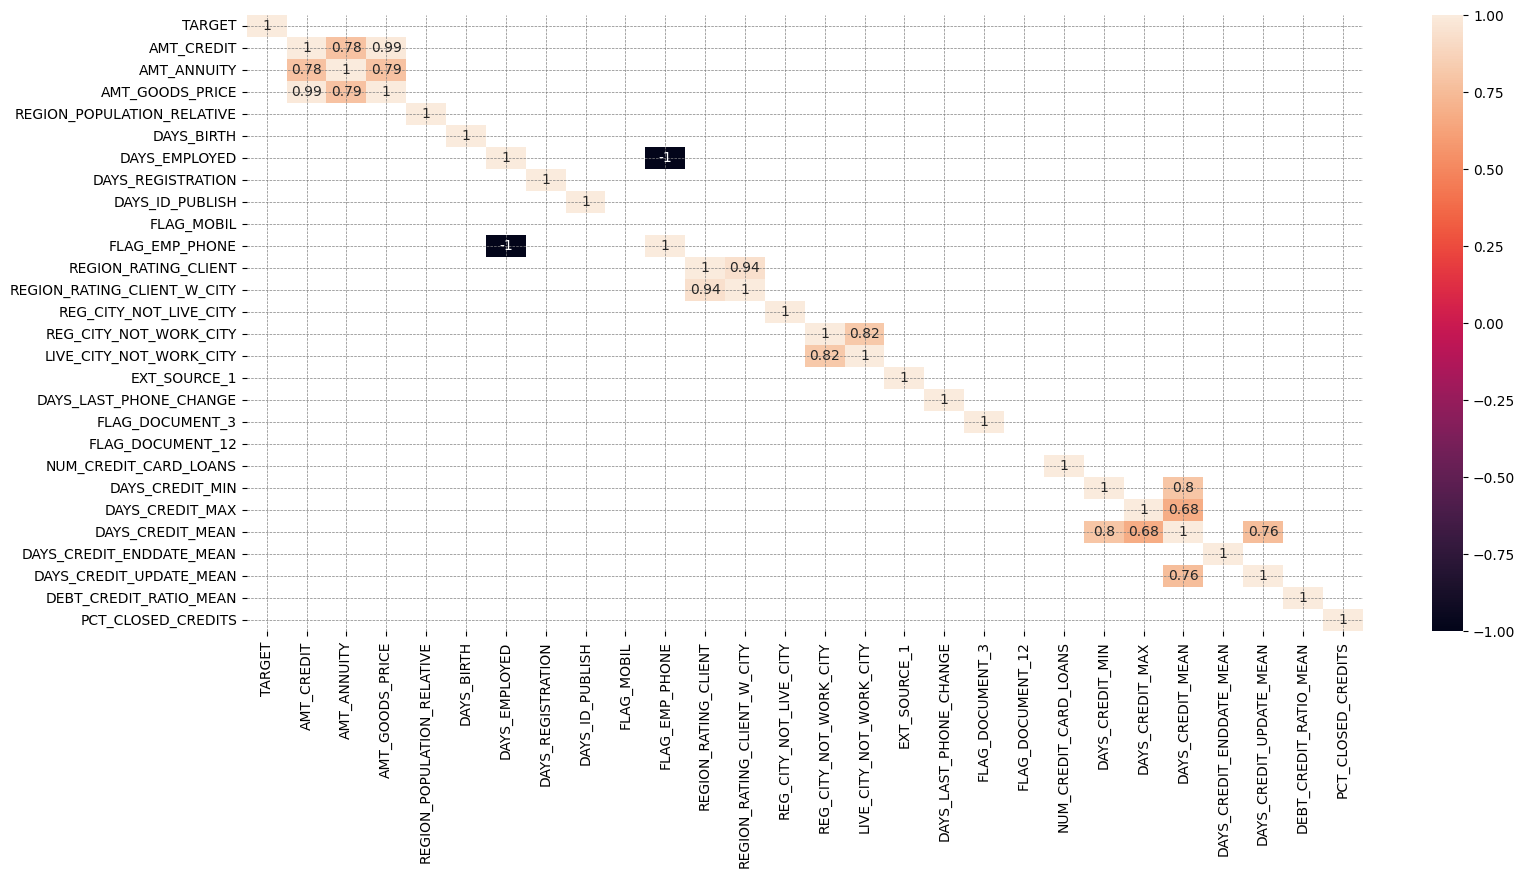

In [19]:
# find high correlations
print_corr_matrix(cleaning, 0.65)

In [20]:
# amt credit, amt annuity, amt goods price have high correlation
    # let's check the amount of null values they have
temp = cleaning[['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']]
print(temp.isna().sum())

# let's also check their IVs
print(round(iv_dict['AMT_CREDIT'],4))
print(round(iv_dict['AMT_ANNUITY'],4))
print(round(iv_dict['AMT_GOODS_PRICE'],4))

# based on all the info, let's drop rows where AMT_GOODS_PRICE is empty
    # then combine AMT_GOODS_PRICE and AMT_CREDIT as a new variable
    # then drop the original 3 columns
cleaning = cleaning.dropna(subset=['AMT_GOODS_PRICE'])
cleaning['PCT_AMT_CREDIT_TO_GOODSPRICE'] = cleaning['AMT_CREDIT'] / cleaning['AMT_GOODS_PRICE']
to_drop = ['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']
cleaning = cleaning.drop(columns=to_drop)

AMT_CREDIT           0
AMT_ANNUITY          9
AMT_GOODS_PRICE    256
dtype: int64
0.0426
0.0227
0.0473


In [21]:
# find number of nulls & IV of variables with high correlations
temp = [
    'FLAG_EMP_PHONE', 'DAYS_EMPLOYED', 
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
    'LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY', 
    'DAYS_CREDIT_MIN', 'DAYS_CREDIT_MEAN', 'DAYS_CREDIT_MAX', 'DAYS_CREDIT_UPDATE_MEAN'
]

print(cleaning[temp].isna().sum())
for col in temp:
    print(f"{col}: {round(iv_dict[col],4)}")

# based on the printed info, we can drop the following columns
to_drop = ['FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'LIVE_CITY_NOT_WORK_CITY', 'DAYS_CREDIT_MIN', 'DAYS_CREDIT_MAX', 'DAYS_CREDIT_UPDATE_MEAN']
cleaning = cleaning.drop(columns=to_drop)

FLAG_EMP_PHONE                     0
DAYS_EMPLOYED                      0
REGION_RATING_CLIENT               0
REGION_RATING_CLIENT_W_CITY        0
LIVE_CITY_NOT_WORK_CITY            0
REG_CITY_NOT_WORK_CITY             0
DAYS_CREDIT_MIN                15566
DAYS_CREDIT_MEAN               15566
DAYS_CREDIT_MAX                15566
DAYS_CREDIT_UPDATE_MEAN        15566
dtype: int64
FLAG_EMP_PHONE: 0.0485
DAYS_EMPLOYED: 0.1267
REGION_RATING_CLIENT: 0.0444
REGION_RATING_CLIENT_W_CITY: 0.047
LIVE_CITY_NOT_WORK_CITY: 0.0215
REG_CITY_NOT_WORK_CITY: 0.0446
DAYS_CREDIT_MIN: 0.0785
DAYS_CREDIT_MEAN: 0.1201
DAYS_CREDIT_MAX: 0.0774
DAYS_CREDIT_UPDATE_MEAN: 0.0948


In [22]:
# based some potentially iffy / irrelevant categorical columns
    # also checked the IVs for these columns
to_drop = [
    'NAME_EDUCATION_TYPE', # may be biased, IV = 0.0403
    'NAME_FAMILY_STATUS', # may be biased, IV = 0.0227
    'HOUSETYPE_MODE', # may be biased, IV = 0.0232
    'EMERGENCYSTATE_MODE' # housing related, may be irrelevant, IV = 0.0252
]
cleaning = cleaning.drop(columns=to_drop)

In [23]:
print(cleaning.columns.tolist())
print(len(cleaning.columns))

['TARGET', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_12', 'NUM_CREDIT_CARD_LOANS', 'DAYS_CREDIT_MEAN', 'DAYS_CREDIT_ENDDATE_MEAN', 'DEBT_CREDIT_RATIO_MEAN', 'PCT_CLOSED_CREDITS', 'PCT_AMT_CREDIT_TO_GOODSPRICE']
23


### Look at Categorical Columns
- bin them using scorecard py 
- get the bins and map the values
    - to one hot encode after

In [24]:
print(cleaning.select_dtypes(include='object').columns.tolist())
print(len(cleaning.select_dtypes(include='object').columns))
print(len(cleaning.select_dtypes(include=['float64', 'int64']).columns))

temp = cleaning.copy()

['NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']
3
20


In [25]:
bins = sc.woebin(temp[['TARGET', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']], y='TARGET')

for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1
    # print('IV: ' + str(round(bindetails['total_iv'][0], 4)))
    # display(bindetails)

[INFO] creating woe binning ...


##### Calculate WOE and IV manually

In [26]:
def woe_iv(data, variable_name):
    working_data = data.copy()

    # Handle missing values
    working_data[variable_name].fillna('Missing', inplace=True)

    # Create a new dataframe for the calculations
    df = pd.DataFrame()
    df['Bins'] = working_data[variable_name].unique()
    df['Count'] = df['Bins'].map(working_data[variable_name].value_counts())
    df['Events'] = df['Bins'].map(working_data.groupby(variable_name)['TARGET'].sum())
    df['Non_Events'] = df['Count'] - df['Events']
    df['%_Events'] = df['Events'] / sum(df['Events'])
    df['%_Non_Events'] = df['Non_Events'] / sum(df['Non_Events'])
    df['WOE'] = np.log(df['%_Non_Events'] / df['%_Events'])
    df['IV'] = (df['%_Non_Events'] - df['%_Events']) * df['WOE']

    IV = sum(df['IV'])

    return IV, df

##### Handle NAME_INCOME_TYPE variable

In [27]:
print('IV: ' + str(round(bins['NAME_INCOME_TYPE']['total_iv'][0], 4)))
display(bins['NAME_INCOME_TYPE'])

# print the bins
print(bins['NAME_INCOME_TYPE']['bin'].tolist())

iv, df = woe_iv(temp, 'NAME_INCOME_TYPE')
df.sort_values(by='IV')

IV: 0.0726


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Businessman%,%Maternity leave%,%Student%,%Pens...",41754,0.223245,39525,2229,0.053384,0.462696,0.039464,0.072576,"Businessman%,%Maternity leave%,%Student%,%Pens...",False
1,NAME_INCOME_TYPE,State servant,13353,0.071394,12571,782,0.058564,0.364608,0.008158,0.072576,State servant,False
2,NAME_INCOME_TYPE,Commercial associate,40547,0.216792,37316,3231,0.079685,0.033946,0.000246,0.072576,Commercial associate,False
3,NAME_INCOME_TYPE,"Working%,%Unemployed",91378,0.488569,82244,9134,0.099958,-0.214998,0.024708,0.072576,"Working%,%Unemployed",False


['Businessman%,%Maternity leave%,%Student%,%Pensioner', 'State servant', 'Commercial associate', 'Working%,%Unemployed']


,Bins,Count,Events,Non_Events,%_Events,%_Non_Events,WOE,IV
4,Unemployed,11,2,9,0.000130,0.000052,-0.908607,0.000071
3,Commercial associate,40547,3231,37316,0.210133,0.217388,0.033946,0.000246
1,State servant,13353,782,12571,0.050858,0.073234,0.364608,0.008158
0,Working,91367,9132,82235,0.593913,0.479069,-0.214888,0.024679
2,Pensioner,41737,2229,39508,0.144966,0.230158,0.462266,0.039381
5,Student,12,0,12,0.000000,0.000070,inf,inf
6,Businessman,2,0,2,0.000000,0.000012,inf,inf
7,Maternity leave,3,0,3,0.000000,0.000017,inf,inf


In [28]:
# change the breaks bc original breaks don't make sense
breaks = {'NAME_INCOME_TYPE': [
    'Working%,%Maternity leave%,%Businessman%,%Student', 'State servant%,%Unemployed%,%Commercial associate', 'Pensioner'
]}
bins2 = sc.woebin(temp[['TARGET', 'NAME_INCOME_TYPE']], y='TARGET', breaks_list=breaks)
for variable, bindetails in bins2.items():
    bins2[variable]['woe'] = bins2[variable]['woe'] * -1
    display(bindetails)

[INFO] creating woe binning ...


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,NAME_INCOME_TYPE,"Working%,%Maternity leave%,%Businessman%,%Student",91384,0.488601,82252,9132,0.099930,-0.214682,0.024634,0.067184,"Working%,%Maternity leave%,%Businessman%,%Student",False
1,NAME_INCOME_TYPE,"State servant%,%Unemployed%,%Commercial associate",53911,0.288245,49896,4015,0.074475,0.107219,0.003169,0.067184,"State servant%,%Unemployed%,%Commercial associate",False
2,NAME_INCOME_TYPE,Pensioner,41737,0.223154,39508,2229,0.053406,0.462266,0.039381,0.067184,Pensioner,False


In [29]:
# save the bins into temp dataframe
mapping = {
    'Businessman': 'Working_Businessman_Maternity leave_Student',
    'Maternity leave': 'Working_Businessman_Maternity leave_Student',
    'Student': 'Working_Businessman_Maternity leave_Student',
    'Working': 'Working_Businessman_Maternity leave_Student',
    'Commercial associate': 'State servant_Unemployed_Commercial associate',
    'State servant': 'State servant_Unemployed_Commercial associate',
    'Unemployed': 'State servant_Unemployed_Commercial associate',
}
# save IVs of the individual bins for later
iv_dict_categorical = {
    'NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student': 0.024634,
    'NAME_INCOME_TYPE_State servant_Unemployed_Commercial associate': 0.003169,
    'NAME_INCOME_TYPE_Pensioner': 0.039381,
}
temp['NAME_INCOME_TYPE'] = temp['NAME_INCOME_TYPE'].replace(mapping)

##### Handle OCCUPATION_TYPE variable

In [30]:
print('IV: ' + str(round(bins['OCCUPATION_TYPE']['total_iv'][0], 4)))
display(bins['OCCUPATION_TYPE'])

# print the bins
print(bins['OCCUPATION_TYPE']['bin'].tolist())

IV: 0.0902


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,OCCUPATION_TYPE,missing,66434,0.355201,62179,4255,0.064049,0.269238,0.023020,0.09019,missing,True
1,OCCUPATION_TYPE,"Accountants%,%Core staff%,%Managers%,%IT staff...",49627,0.265340,46377,3250,0.065489,0.245464,0.014435,0.09019,"Accountants%,%Core staff%,%Managers%,%IT staff...",False
2,OCCUPATION_TYPE,"Cleaning staff%,%Sales staff%,%Cooking staff",29319,0.156759,26430,2889,0.098537,-0.199095,0.006753,0.09019,"Cleaning staff%,%Sales staff%,%Cooking staff",False
3,OCCUPATION_TYPE,"Security staff%,%Laborers%,%Waiters/barmen sta...",41652,0.222700,36670,4982,0.119610,-0.416557,0.045982,0.09019,"Security staff%,%Laborers%,%Waiters/barmen sta...",False


['missing', 'Accountants%,%Core staff%,%Managers%,%IT staff%,%High skill tech staff%,%HR staff%,%Private service staff%,%Medicine staff%,%Secretaries%,%Realty agents', 'Cleaning staff%,%Sales staff%,%Cooking staff', 'Security staff%,%Laborers%,%Waiters/barmen staff%,%Drivers%,%Low-skill Laborers']


In [31]:
temp['OCCUPATION_TYPE'].fillna('missing', inplace=True)
mapping = {
    'Accountants': 'bin1',
    'Core staff': 'bin1',
    'Managers': 'bin1',
    'IT staff': 'bin1',
    'High skill tech staff': 'bin1',
    'HR staff': 'bin1',
    'Private service staff': 'bin1',
    'Medicine staff': 'bin1',
    'Secretaries': 'bin1',
    'Realty agents': 'bin1',
    'Cleaning staff': 'bin2',
    'Sales staff': 'bin2',
    'Cooking staff': 'bin2',
    'Security staff': 'bin3',
    'Laborers': 'bin3',
    'Waiters/barmen staff': 'bin3',
    'Drivers': 'bin3',
    'Low-skill Laborers': 'bin3'
}
temp['OCCUPATION_TYPE'] = temp['OCCUPATION_TYPE'].replace(mapping)

# save the IVs
iv_dict_categorical['OCCUPATION_TYPE_bin1'] = 0.014435
iv_dict_categorical['OCCUPATION_TYPE_bin2'] = 0.006753
iv_dict_categorical['OCCUPATION_TYPE_bin3'] = 0.045982
iv_dict_categorical['OCCUPATION_TYPE_missing'] = 0.023020

##### Handle ORGANIZATION_TYPE variable

In [32]:
print('IV: ' + str(round(bins['ORGANIZATION_TYPE']['total_iv'][0], 4)))
display(bins['ORGANIZATION_TYPE'])

# print the bins
print(bins['ORGANIZATION_TYPE']['bin'].tolist())

IV: 0.0753


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ORGANIZATION_TYPE,"University%,%Culture%,%Security Ministries%,%X...",51858,0.277268,49063,2795,0.053897,0.452588,0.047089,0.075252,"University%,%Culture%,%Security Ministries%,%X...",False
1,ORGANIZATION_TYPE,"Services%,%Public Sector%,%Medicine%,%Religion...",22974,0.122835,21386,1588,0.069122,0.187577,0.003997,0.075252,"Services%,%Public Sector%,%Medicine%,%Religion...",False
2,ORGANIZATION_TYPE,"Other%,%Electricity%,%Telecom%,%Housing%,%Post...",112200,0.599897,101207,10993,0.097977,-0.192775,0.024165,0.075252,"Other%,%Electricity%,%Telecom%,%Housing%,%Post...",False


['University%,%Culture%,%Security Ministries%,%XNA%,%Financial Services%,%School', 'Services%,%Public Sector%,%Medicine%,%Religion%,%Emergency%,%Kindergarten', 'Other%,%Electricity%,%Telecom%,%Housing%,%Postal%,%Cleaning%,%Trade%,%Industry%,%Legal Services%,%Business Entity%,%Mobile%,%Advertising%,%Transport%,%Self-employed%,%Hospitality%,%Agriculture%,%Security%,%Construction%,%Realtor']


In [33]:
mapping = {
    'University': 'bin1',
    'Culture': 'bin1',
    'Security Ministries': 'bin1',
    'XNA': 'bin1',
    'Financial Services': 'bin1',
    'School': 'bin1',
    'Services': 'bin2',
    'Public Sector': 'bin2',
    'Medicine': 'bin2',
    'Religion': 'bin2',
    'Emergency': 'bin2',
    'Kindergarten': 'bin2',
    'Other': 'bin3',
    'Electricity': 'bin3',
    'Telecom': 'bin3',
    'Housing': 'bin3',
    'Postal': 'bin3',
    'Cleaning': 'bin3',
    'Trade': 'bin3',
    'Industry': 'bin3',
    'Legal Services': 'bin3',
    'Business Entity': 'bin3',
    'Mobile': 'bin3',
    'Advertising': 'bin3',
    'Transport': 'bin3',
    'Self-employed': 'bin3',
    'Hospitality': 'bin3',
    'Agriculture': 'bin3',
    'Security': 'bin3',
    'Construction': 'bin3',
    'Realtor': 'bin3',
}
temp['ORGANIZATION_TYPE'] = temp['ORGANIZATION_TYPE'].replace(mapping)

# save the IVs
iv_dict_categorical['ORGANIZATION_TYPE_bin1'] = 0.047089
iv_dict_categorical['ORGANIZATION_TYPE_bin2'] = 0.003997
iv_dict_categorical['ORGANIZATION_TYPE_bin3'] = 0.024165

##### Dummy encoding and then calculate correlation

In [34]:
cats = temp.select_dtypes(include='object').columns.tolist()
encoded = pd.get_dummies(temp, columns=cats, drop_first=False, dtype=int)
encoded.head()

,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant_Unemployed_Commercial associate,NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student,OCCUPATION_TYPE_bin1,OCCUPATION_TYPE_bin2,OCCUPATION_TYPE_bin3,OCCUPATION_TYPE_missing,ORGANIZATION_TYPE_bin1,ORGANIZATION_TYPE_bin2,ORGANIZATION_TYPE_bin3
0,1,0.018801,-9461,-637,-3648.0,-2120,1,2,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0,0.003541,-16765,-1188,-1186.0,-291,1,1,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0,0.028663,-19932,-3038,-4311.0,-3458,1,2,0,1,...,0,0,1,1,0,0,0,0,1,0
4,0,0.035792,-16941,-1588,-4970.0,-477,1,2,0,0,...,0,1,0,0,0,1,0,0,0,1
5,0,0.018634,-20099,365243,-7427.0,-3514,1,2,0,0,...,1,0,0,0,0,0,1,1,0,0


In [35]:
# drop those with low IV, below 0.02
print(iv_dict_categorical)
to_drop = [key for key, value in iv_dict_categorical.items() if value < 0.02]
encoded = encoded.drop(columns=to_drop)

{'NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student': 0.024634, 'NAME_INCOME_TYPE_State servant_Unemployed_Commercial associate': 0.003169, 'NAME_INCOME_TYPE_Pensioner': 0.039381, 'OCCUPATION_TYPE_bin1': 0.014435, 'OCCUPATION_TYPE_bin2': 0.006753, 'OCCUPATION_TYPE_bin3': 0.045982, 'OCCUPATION_TYPE_missing': 0.02302, 'ORGANIZATION_TYPE_bin1': 0.047089, 'ORGANIZATION_TYPE_bin2': 0.003997, 'ORGANIZATION_TYPE_bin3': 0.024165}


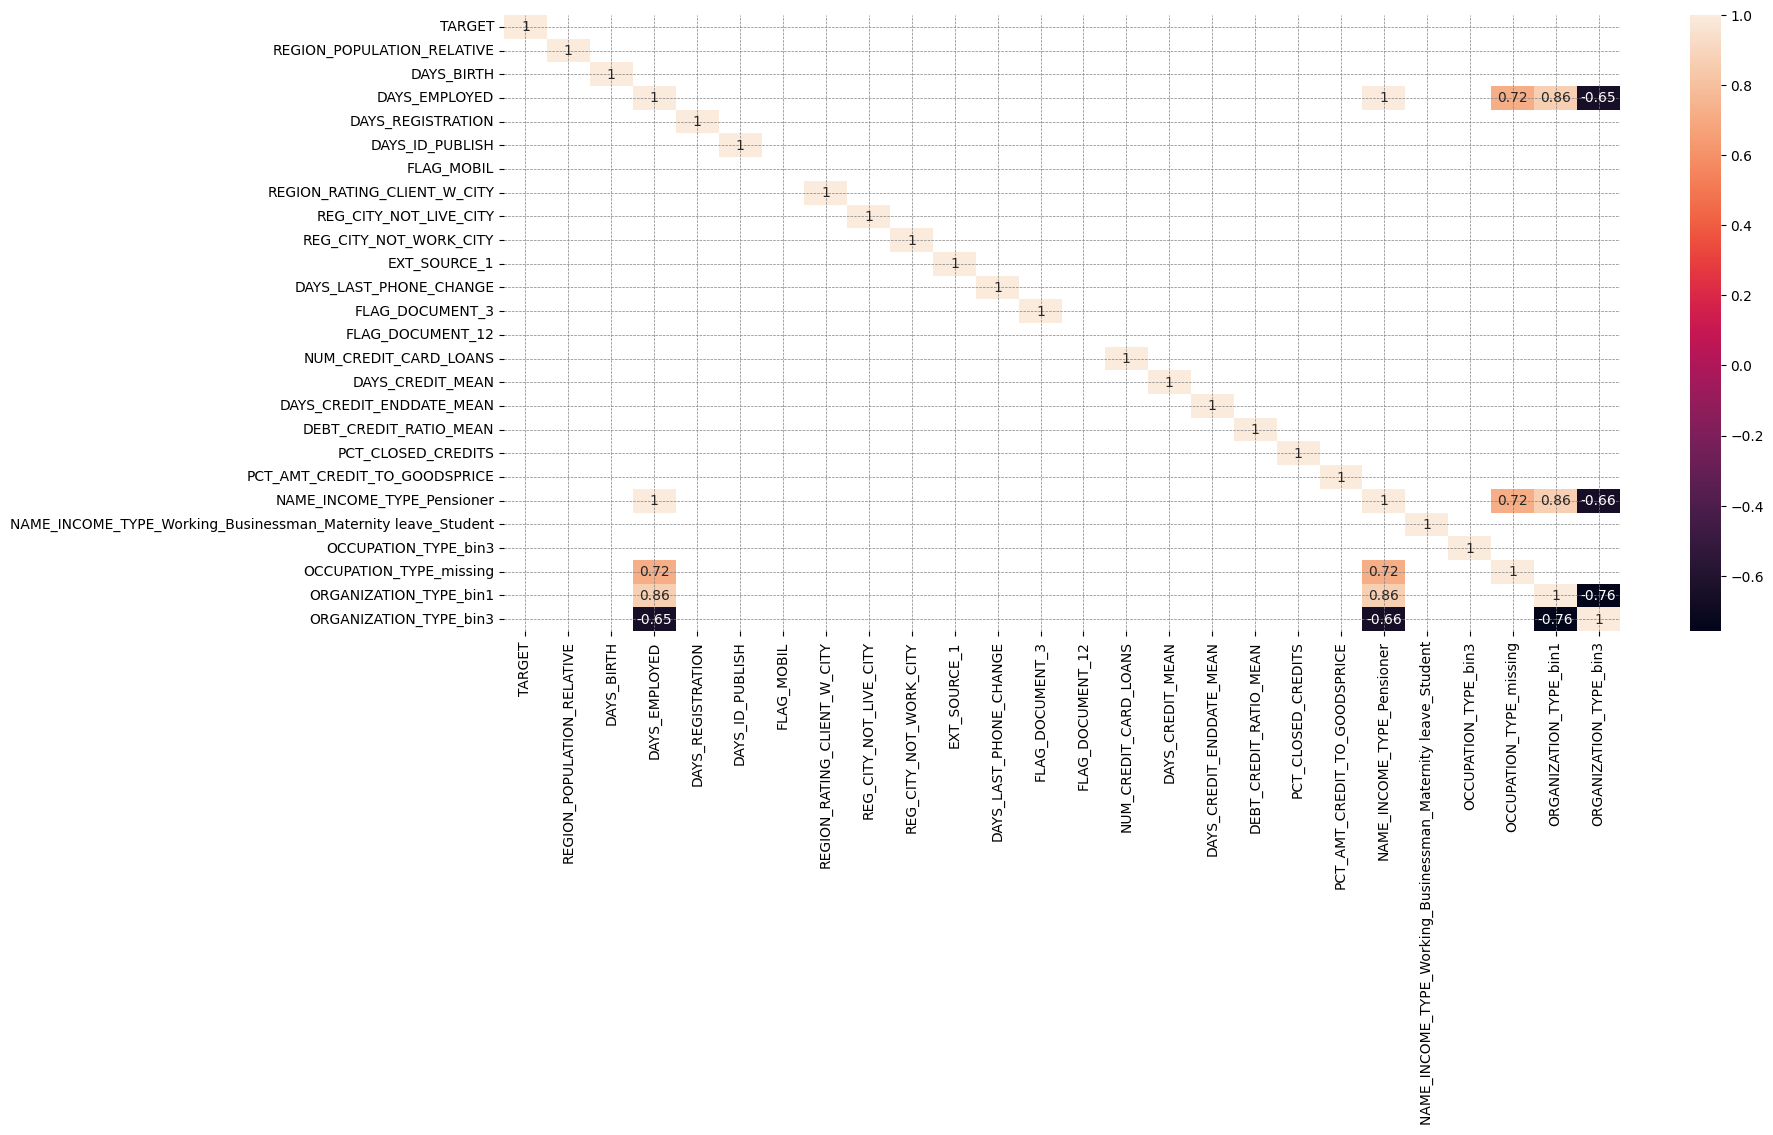

In [36]:
# check correlation
print_corr_matrix(encoded, 0.65)

In [37]:
# check those with high correlation
print(iv_dict['DAYS_EMPLOYED'])
print(iv_dict_categorical['NAME_INCOME_TYPE_Pensioner'])
print(iv_dict_categorical['OCCUPATION_TYPE_missing'])
print(iv_dict_categorical['ORGANIZATION_TYPE_bin1'])
print(iv_dict_categorical['ORGANIZATION_TYPE_bin3'])

# based on this info, let's drop these columns
to_drop = ['NAME_INCOME_TYPE_Pensioner', 'OCCUPATION_TYPE_missing', 'ORGANIZATION_TYPE_bin1', 'ORGANIZATION_TYPE_bin3']
encoded = encoded.drop(columns=to_drop)

0.126721211516148
0.039381
0.02302
0.047089
0.024165


# Drop more columns (yall can play around w what you drop here)
- for scorecard tuning

In [38]:
encoded.head()

,TARGET,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,FLAG_DOCUMENT_3,FLAG_DOCUMENT_12,NUM_CREDIT_CARD_LOANS,DAYS_CREDIT_MEAN,DAYS_CREDIT_ENDDATE_MEAN,DEBT_CREDIT_RATIO_MEAN,PCT_CLOSED_CREDITS,PCT_AMT_CREDIT_TO_GOODSPRICE,NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student,OCCUPATION_TYPE_bin3
0,1,0.018801,-9461,-637,-3648.0,-2120,1,2,0,0,...,1,0,4.0,-874.000000,-349.000000,0.136545,0.750000,1.158397,1,1
1,0,0.003541,-16765,-1188,-1186.0,-291,1,1,0,0,...,1,0,2.0,-1400.750000,-544.500000,0.000000,0.750000,1.145199,0,0
3,0,0.028663,-19932,-3038,-4311.0,-3458,1,2,0,1,...,0,0,0.0,-1149.000000,-783.000000,0.000000,1.000000,1.000000,1,0
4,0,0.035792,-16941,-1588,-4970.0,-477,1,2,0,0,...,1,0,0.0,-757.333333,-391.333333,0.299018,0.666667,1.079198,0,1
5,0,0.018634,-20099,365243,-7427.0,-3514,1,2,0,0,...,1,0,1.0,-1773.000000,-1293.250000,0.000000,1.000000,1.116158,0,0


In [39]:
bins = sc.woebin(encoded, y='TARGET')

# initialise dict
iv_dict = {}

for variable, bindetails in bins.items():
    bins[variable]['woe'] = bins[variable]['woe'] * -1
    iv_dict[variable] = round(bindetails['total_iv'][0], 4)

[INFO] creating woe binning ...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .stack().replace('missing', np.nan) \
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scorecardpy/woebin.py:141: FutureWarning: The provided callable <built-in function su

In [40]:
iv_dict = dict(sorted(iv_dict.items(), key=lambda item: item[1], reverse=True))
print(f'Total number of rows: {len(encoded)}')

for key, value in iv_dict.items():
    print(f'{key}: IV = {value}')
    print(f'\tNumber of missing values: {encoded[key].isna().sum()}')
    print(f'\tPercentage of missing values: {round(encoded[key].isna().sum() / len(encoded),3)}')

print(encoded.columns.tolist())

Total number of rows: 187032
EXT_SOURCE_1: IV = 0.1517
	Number of missing values: 107657
	Percentage of missing values: 0.576
DEBT_CREDIT_RATIO_MEAN: IV = 0.1279
	Number of missing values: 21369
	Percentage of missing values: 0.114
DAYS_EMPLOYED: IV = 0.1248
	Number of missing values: 0
	Percentage of missing values: 0.0
DAYS_CREDIT_MEAN: IV = 0.1214
	Number of missing values: 15566
	Percentage of missing values: 0.083
DAYS_BIRTH: IV = 0.1137
	Number of missing values: 0
	Percentage of missing values: 0.0
PCT_CLOSED_CREDITS: IV = 0.0942
	Number of missing values: 15686
	Percentage of missing values: 0.084
DAYS_CREDIT_ENDDATE_MEAN: IV = 0.0719
	Number of missing values: 17094
	Percentage of missing values: 0.091
PCT_AMT_CREDIT_TO_GOODSPRICE: IV = 0.0701
	Number of missing values: 0
	Percentage of missing values: 0.0
OCCUPATION_TYPE_bin3: IV = 0.0627
	Number of missing values: 0
	Percentage of missing values: 0.0
NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student: IV = 0.0532
	

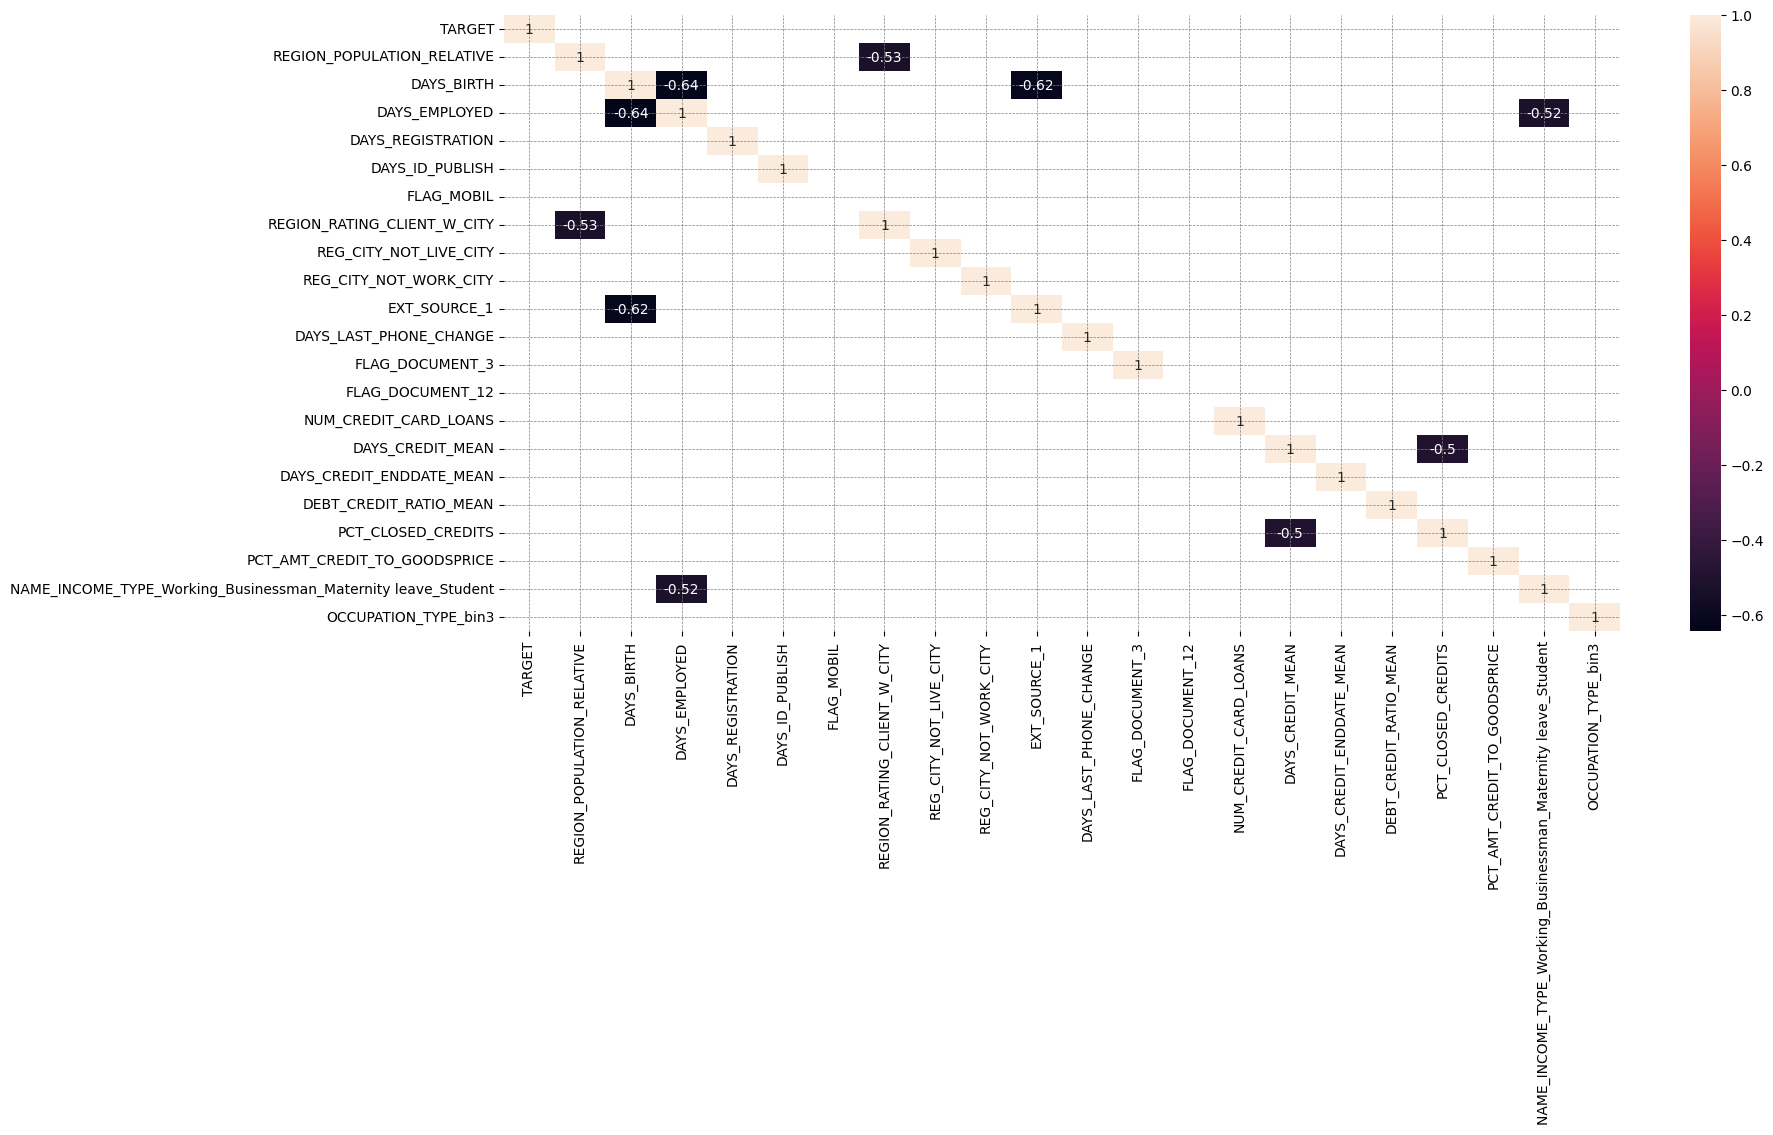

In [41]:
print_corr_matrix(encoded, 0.5)

In [42]:
to_drop = [
    'FLAG_DOCUMENT_12', 'NUM_CREDIT_CARD_LOANS', 'REG_CITY_NOT_LIVE_CITY', # iv below 0.04
    'FLAG_DOCUMENT_3', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'REG_CITY_NOT_WORK_CITY', # iv below 0.04
    'DAYS_BIRTH', # potentially biased + relatively high correlation
    'EXT_SOURCE_1', # many missing values (more than half the dataset)
]

encoded = encoded.drop(columns=to_drop)

In [43]:
encoded

,TARGET,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,REGION_RATING_CLIENT_W_CITY,DAYS_LAST_PHONE_CHANGE,DAYS_CREDIT_MEAN,DAYS_CREDIT_ENDDATE_MEAN,DEBT_CREDIT_RATIO_MEAN,PCT_CLOSED_CREDITS,PCT_AMT_CREDIT_TO_GOODSPRICE,NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student,OCCUPATION_TYPE_bin3
0,1,-637,-2120,1,2,-1134.0,-874.000000,-349.000000,0.136545,0.750000,1.158397,1,1
1,0,-1188,-291,1,1,-828.0,-1400.750000,-544.500000,0.000000,0.750000,1.145199,0,0
3,0,-3038,-3458,1,2,-1106.0,-1149.000000,-783.000000,0.000000,1.000000,1.000000,1,0
4,0,-1588,-477,1,2,-2536.0,-757.333333,-391.333333,0.299018,0.666667,1.079198,0,1
5,0,365243,-3514,1,2,0.0,-1773.000000,-1293.250000,0.000000,1.000000,1.116158,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202919,0,-236,-1982,1,1,-273.0,NaN,NaN,NaN,NaN,1.132000,1,0
202920,0,365243,-4090,1,2,0.0,NaN,NaN,NaN,NaN,1.198000,0,0
202921,0,-7921,-5150,1,3,-1909.0,-867.500000,280.500000,0.299308,0.500000,1.158400,1,0
202922,1,-4786,-931,1,2,-322.0,-1104.000000,-859.000000,0.000000,1.000000,1.158394,0,1


# Bin WOEs to achieve monotonicity
- source for Binning function: https://github.com/jstephenj14/Monotonic-WOE-Binning-Algorithm/blob/master/monotonic_binning/monotonic_woe_binning.py
    - derives the bins where monotonicity is achieved
- implementation: https://lelesgaray.github.io/blog/scorecard/

In [44]:
# !pip install monotonic-binning

In [45]:
from monotonic_binning.monotonic_woe_binning import Binning 

# split data into test and train
train, test = sc.split_df(encoded, 'TARGET', ratio=0.7, seed=42).values()

x_vars = train.drop(['TARGET'], axis=1).columns
y_var = train['TARGET']

def get_breaks_for_monotonicity(x_vars, y_var_name):
  bin_object = Binning(y_var_name, n_threshold=50, y_threshold=10, p_threshold=0.35, sign=False)
  breaks = {}
  for var in x_vars:
    bin_object.fit(train[[y_var_name, var]])
    breaks[var] = (bin_object.bins[1:-1].tolist())
    print(f'check: {var} fitting done')
  return breaks

new_breaks = get_breaks_for_monotonicity(x_vars, 'TARGET')

ModuleNotFoundError: No module named 'monotonic_binning'

[INFO] creating woe binning ...


/Users/caraloo/opt/anaconda3/envs/app_env/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/caraloo/opt/anaconda3/envs/app_env/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  binning_sv = pd.merge(
/Users/caraloo/opt/anaconda3/envs/app_env/lib/python3.9/site-packages/scorecardpy/woebin.py:136: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavi

Binning on 187032 rows and 12 columns in 00:00:18


{'DAYS_ID_PUBLISH': <Figure size 640x480 with 2 Axes>,
 'DAYS_EMPLOYED': <Figure size 640x480 with 2 Axes>,
 'NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student': <Figure size 640x480 with 2 Axes>,
 'PCT_AMT_CREDIT_TO_GOODSPRICE': <Figure size 640x480 with 2 Axes>,
 'DAYS_CREDIT_MEAN': <Figure size 640x480 with 2 Axes>,
 'DEBT_CREDIT_RATIO_MEAN': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'PCT_CLOSED_CREDITS': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'DAYS_CREDIT_ENDDATE_MEAN': <Figure size 640x480 with 2 Axes>,
 'OCCUPATION_TYPE_bin3': <Figure size 640x480 with 2 Axes>}

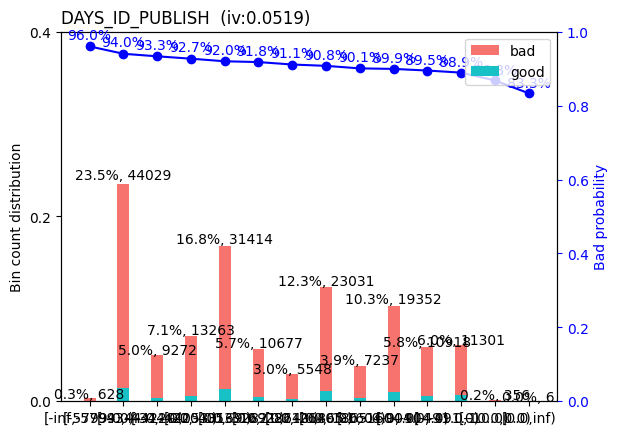

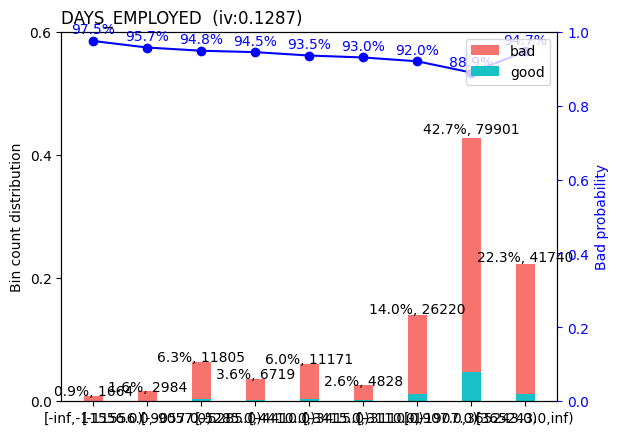

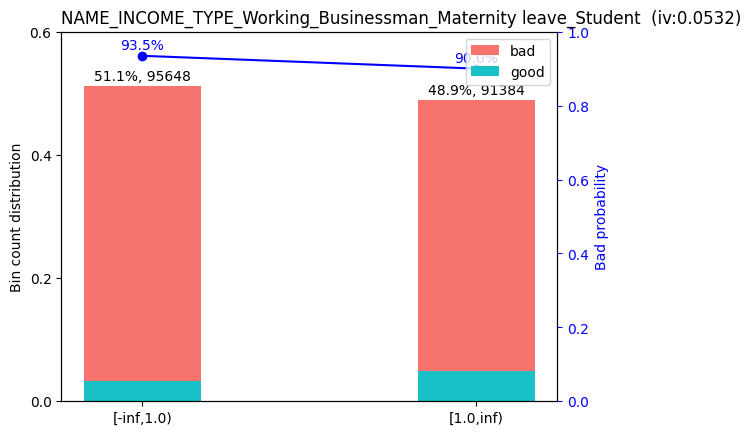

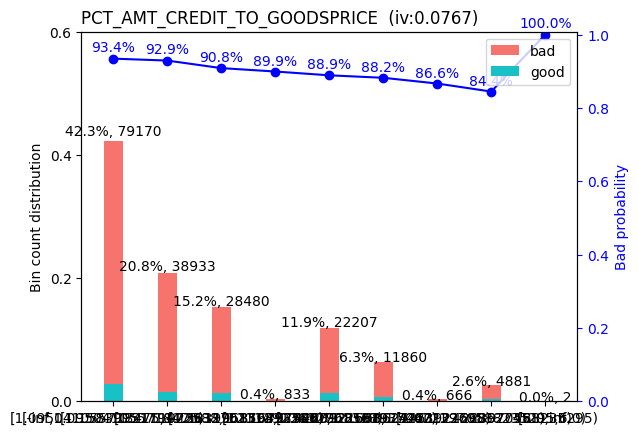

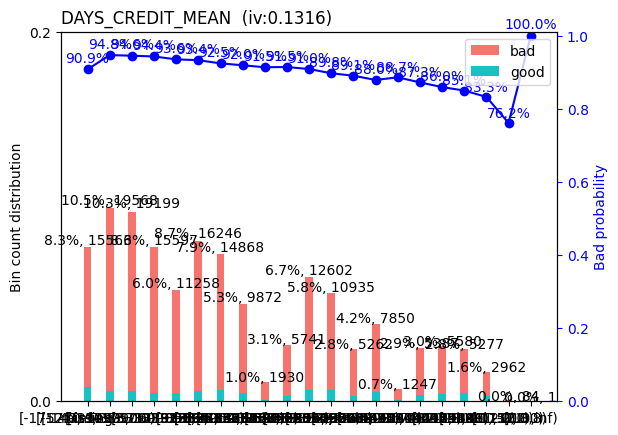

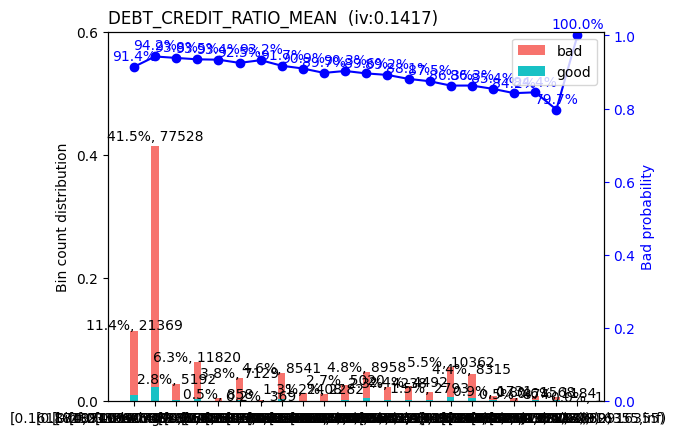

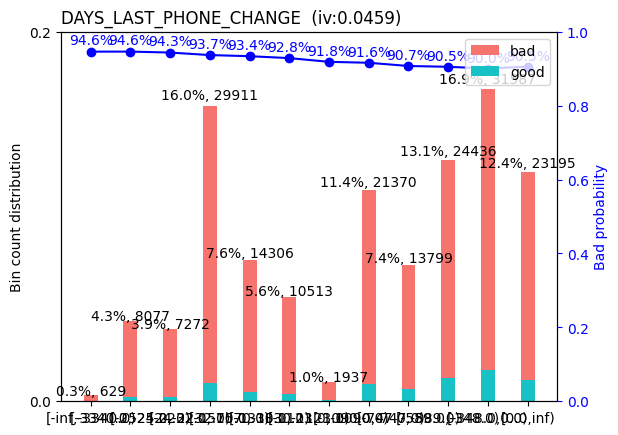

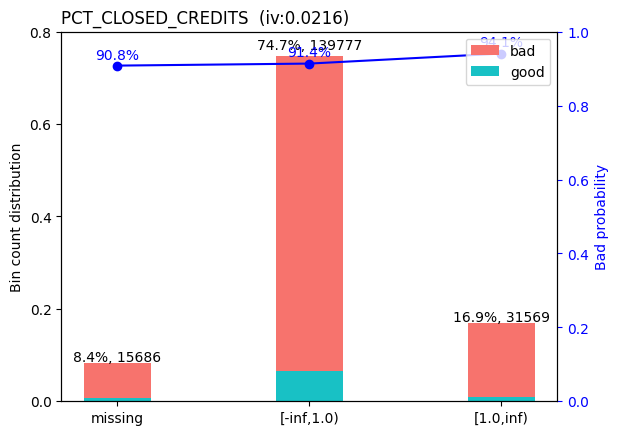

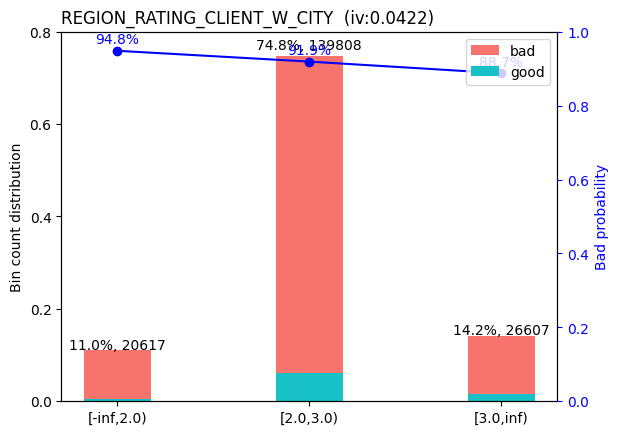

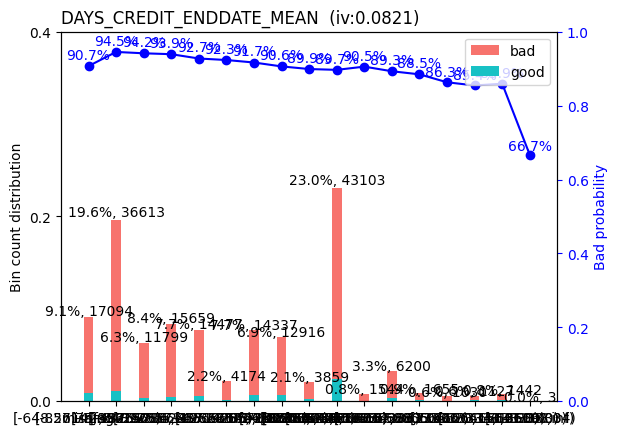

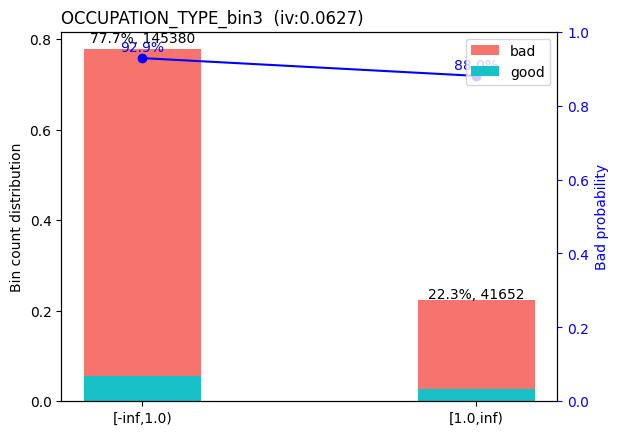

In [ ]:
bins = sc.woebin(encoded, y='TARGET', breaks_list=new_breaks, positive='bad|0') # change positive to reverse WOE sign
sc.woebin_plot(bins)

# Generate Scorecard

In [ ]:
# import stuff
from sklearn import linear_model, metrics
from sklearn.linear_model import LogisticRegression
import pprint

In [ ]:
# encode WOE values
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    train_woe = sc.woebin_ply(train, bins)
    test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
Woe transformating on 130922 rows and 11 columns in 00:00:11
[INFO] converting into woe values ...


In [ ]:
# create the X, y parts of data for train and test
y_train = train_woe.loc[:, 'TARGET']
X_train = train_woe.loc[:, train_woe.columns != 'TARGET']
y_test = test_woe.loc[:, 'TARGET']
X_test = test_woe.loc[:, train_woe.columns != 'TARGET']

# create and fit model
lr = linear_model.LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

# find coefficients
coeff = pd.Series(np.concatenate([lr.intercept_, lr.coef_[0]]),index = np.concatenate([['intercept'], lr.feature_names_in_]))
coeff

intercept                                                           0.001197
FLAG_MOBIL                                                          0.001190
DAYS_ID_PUBLISH_woe                                                -0.374800
DAYS_EMPLOYED_woe                                                  -0.585880
NAME_INCOME_TYPE_Working_Businessman_Maternity leave_Student_woe   -0.300725
PCT_AMT_CREDIT_TO_GOODSPRICE_woe                                   -0.863637
DAYS_CREDIT_MEAN_woe                                               -0.372904
DEBT_CREDIT_RATIO_MEAN_woe                                         -0.646912
DAYS_LAST_PHONE_CHANGE_woe                                         -0.581607
PCT_CLOSED_CREDITS_woe                                             -0.081918
REGION_RATING_CLIENT_W_CITY_woe                                    -0.951115
DAYS_CREDIT_ENDDATE_MEAN_woe                                       -0.103214
OCCUPATION_TYPE_bin3_woe                                           -0.680134

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    card = sc.scorecard(bins, lr, X_train.columns, points0=600, odds0=1/20, pdo=20, basepoints_eq0=True)

pprint.pprint(card)

{'DAYS_CREDIT_ENDDATE_MEAN':                      variable                                        bin  points
95   DAYS_CREDIT_ENDDATE_MEAN                                    missing    42.0
96   DAYS_CREDIT_ENDDATE_MEAN                             [-inf,-826.75)    44.0
97   DAYS_CREDIT_ENDDATE_MEAN               [-826.75,-648.5714285714286)    44.0
98   DAYS_CREDIT_ENDDATE_MEAN    [-648.5714285714286,-437.6666666666667)    44.0
99   DAYS_CREDIT_ENDDATE_MEAN               [-437.6666666666667,-250.75)    43.0
100  DAYS_CREDIT_ENDDATE_MEAN              [-250.75,-196.92857142857142)    43.0
101  DAYS_CREDIT_ENDDATE_MEAN  [-196.92857142857142,-13.285714285714286)    43.0
102  DAYS_CREDIT_ENDDATE_MEAN                [-13.285714285714286,173.0)    42.0
103  DAYS_CREDIT_ENDDATE_MEAN                              [173.0,238.5)    42.0
104  DAYS_CREDIT_ENDDATE_MEAN                             [238.5,4171.5)    42.0
105  DAYS_CREDIT_ENDDATE_MEAN                 [4171.5,4751.666666666667)    42.0

In [ ]:
# print evaluation metrics of the model
y_pred = lr.predict(X_test)

print('Confusion matrix:')
print(metrics.confusion_matrix(y_test, y_pred))
print('PCC measures:')
print(metrics.classification_report(y_test, y_pred))

Confusion matrix:
[[32982 18515]
 [ 1761  2852]]
PCC measures:
              precision    recall  f1-score   support

           0       0.95      0.64      0.76     51497
           1       0.13      0.62      0.22      4613

    accuracy                           0.64     56110
   macro avg       0.54      0.63      0.49     56110
weighted avg       0.88      0.64      0.72     56110



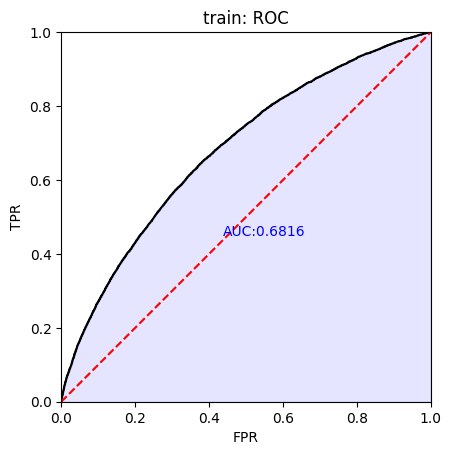

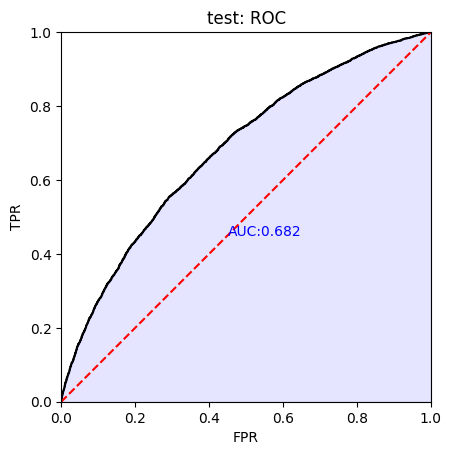

In [ ]:
# performance roc
train_pred = lr.predict_proba(X_train)[:, 1]
test_pred = lr.predict_proba(X_test)[:, 1]
train_perf = sc.perf_eva(y_train, train_pred, plot_type = ['roc'], title = 'train')
test_perf = sc.perf_eva(y_test, test_pred, plot_type = ['roc'], title = 'test')